# SpeakAge - Predicting Child Age from Conversation Data
Author: Adi Salmon, Freida Barnatan


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train and Test

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Final_Project/dataset_with_child_features.csv")

In [ ]:
print(df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'corpus_name', 'file_name', 'child_age',
       'child_name', 'participants', 'child_group', 'language', 'child_gender',
       'conversation', 'target', 'num_lines', 'num_child_lines', 'total_words',
       'total_child_words', 'avg_child_words_per_line', 'language_set',
       'updated_td_group', 'language_varieties', 'age_half_year', 'age_group',
       'child_involvement', 'n_participants', 'age_bin', 'age_bin_readable',
       'conversation_json', 'child_participation', 'child_word_ratio', 'mtld',
       'vocd', 'mattr', 'mlum', 'kc', 'kc_per_word', 'kc_per_line',
       'clause_density', 'ipsyn', 'ipsyn_per_word', 'narrative_complexity',
       'num_child_turns', 'avg_child_turn_length', 'cohesion',
       'speaking_features', 'MLU', 'max_utt_len', 'speaking_rate',
       'phonological_features', 'avg_word_length', 'vowel_ratio',
       'cluster_ratio', 'phoneme_diversity', 'noun_verb_ratio',
       'specific_grammatical', 'conversation_id'],


In [ ]:
feature_columns = [
    'num_lines', 'num_child_lines', 'total_words', 'total_child_words',
    'avg_child_words_per_line', 'child_participation', 'child_word_ratio',
    'mtld', 'vocd', 'mattr', 'mlum', 'kc', 'kc_per_word', 'kc_per_line',
    'clause_density', 'ipsyn', 'ipsyn_per_word', 'narrative_complexity',
    'num_child_turns', 'avg_child_turn_length', 'cohesion', 'MLU',
    'max_utt_len', 'speaking_rate', 'avg_word_length', 'vowel_ratio',
    'cluster_ratio', 'phoneme_diversity', 'noun_verb_ratio', 'specific_grammatical'
]

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['corpus_name', 'file_name', 'child_name', 'participants',
                    'child_group', 'language', 'child_gender', 'language_set',
                    'updated_td_group', 'language_varieties', 'age_group',
                    'child_involvement', 'specific_grammatical']

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [ ]:
print(df[feature_columns].dtypes)

num_lines                   float64
num_child_lines             float64
total_words                 float64
total_child_words             int64
avg_child_words_per_line    float64
child_participation         float64
child_word_ratio            float64
mtld                        float64
vocd                        float64
mattr                       float64
mlum                        float64
kc                            int64
kc_per_word                 float64
kc_per_line                 float64
clause_density              float64
ipsyn                         int64
ipsyn_per_word              float64
narrative_complexity        float64
num_child_turns             float64
avg_child_turn_length       float64
cohesion                    float64
MLU                         float64
max_utt_len                   int64
speaking_rate               float64
avg_word_length             float64
vowel_ratio                 float64
cluster_ratio               float64
phoneme_diversity           

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

#### LogisticRegression with balance

We implement a basic regression model to predict the child’s `age_bin_readable` from conversation-based features. To handle class imbalance, we compute weights for each age group and incorporate them into a weighted loss function. The model is a simple neural network trained with PyTorch, and its performance is evaluated using the `R²` metric. This setup serves as a starting point for further improvements in model complexity and feature engineering.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1. Convert all to numeric safely
df_features = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# 2. Replace inf/-inf with NaN
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Fill NaNs with column mean (or 0)
df_features.fillna(df_features.mean(), inplace=True)

# 4. Target
y = df['age_bin_readable']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 5. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features.values)

# 6. Stratified train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 7. Logistic Regression with balanced class weights
clf = LogisticRegression(
    max_iter=5000,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='multinomial'
)
clf.fit(X_train, y_train)

# 8. Evaluate
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
print(f"Val Accuracy: {acc:.4f}, Val F1: {f1:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=le.classes_))

# 9. Feature importance
feature_importance = np.abs(clf.coef_).sum(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)
print("\nTop features influencing age prediction:")
print(importance_df)

Val Accuracy: 0.6022, Val F1: 0.5957

Classification Report:

              precision    recall  f1-score   support

         2-3       0.68      0.78      0.73       105
         3-5       0.61      0.46      0.52       170
         5-6       0.52      0.66      0.58        92

    accuracy                           0.60       367
   macro avg       0.60      0.63      0.61       367
weighted avg       0.61      0.60      0.60       367


Top features influencing age prediction:
                     feature  importance
11                        kc    4.248616
17      narrative_complexity    2.848833
10                      mlum    2.010843
5        child_participation    1.899510
6           child_word_ratio    1.882749
3          total_child_words    1.865495
15                     ipsyn    1.644293
7                       mtld    1.032795
1            num_child_lines    1.030119
18           num_child_turns    1.030119
13               kc_per_line    0.698137
14            clause_de

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**2-3** : Highest recall → model predicts this group well. </br>
**3-5**: Recall is low → model often misses this age group, likely because 2-3 or 5-6 dominate predictions.</br>
**5-6**: Recall decent but precision lower → some 5-6 predictions are actually other classes.

Top features:

Feature	Importance	Meaning</br>
**kc**	4.25	Child utterance complexity</br>
**narrative_complexity**	2.85	How complex the child’s story is
**mlum**	2.07	Mean length of utterance</br>
**child_participation**	1.90	How much child speaks</br>
**child_word_ratio**	1.88	Ratio of child words in conversation</br>

These make sense: features directly related to child speech quantity and complexity influence age most.

Low-importance features (like max_utt_len, cluster_ratio) may be noisy or less predictive.

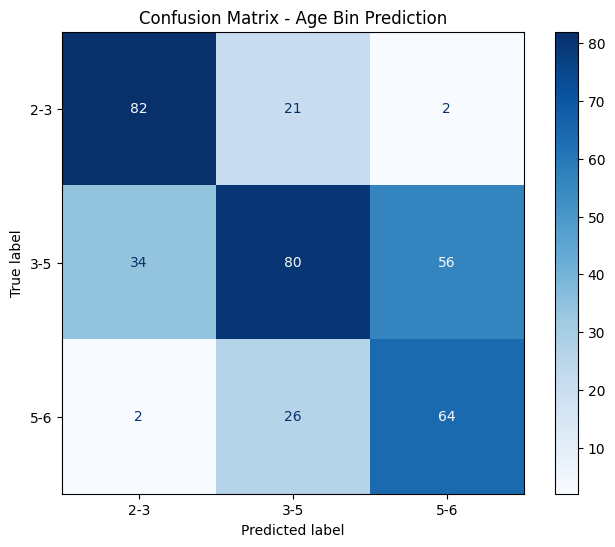

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix - Age Bin Prediction")
plt.show()

### **LinearRegression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np

# 1. Select only numeric features
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# 2. Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Split train and val first to avoid leakage
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, df['child_age'], test_size=0.2, random_state=42
)

# 4. Impute missing values using training set
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Train linear regression
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Predict
y_pred = reg.predict(X_val_scaled)

# Evaluation
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['specific_grammatical']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['specific_grammatical']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


R²: 0.5188, MAE: 7.7570, RMSE: 9.5160


### HistGradientBoostingRegressor

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# No scaling needed for tree-based models
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

model = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

R²: 0.5883, MAE: 6.8844, RMSE: 8.8021


### HistGradientBoostingRegressor with tuning and also get feature importance.

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# --------------------------
# 1. Features and target
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y = df['child_age']

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 2. Model
hgb = HistGradientBoostingRegressor(random_state=42)

# Optional: Grid search to tune parameters
param_grid = {
    'max_iter': [100, 200],
    'max_depth': [3, 5, None],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_leaf': [20, 50, 100]
}

grid = GridSearchCV(hgb, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# --------------------------
# 3. Predictions & metrics
y_pred = best_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

from sklearn.inspection import permutation_importance

# Compute permutation importances
perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=10, random_state=42)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

print(feature_importances)

R²: 0.6126, MAE: 6.6412, RMSE: 8.5385
                     feature  importance
13               kc_per_line    0.283863
12               kc_per_word    0.081743
17      narrative_complexity    0.074277
9                      mattr    0.027142
0                  num_lines    0.025493
24           avg_word_length    0.018287
6           child_word_ratio    0.016820
16            ipsyn_per_word    0.015334
14            clause_density    0.008708
5        child_participation    0.008238
2                total_words    0.007451
20                  cohesion    0.006671
25               vowel_ratio    0.005696
26             cluster_ratio    0.005384
28           noun_verb_ratio    0.004677
7                       mtld    0.002870
27         phoneme_diversity    0.002796
11                        kc    0.002722
15                     ipsyn    0.002103
4   avg_child_words_per_line    0.001843
8                       vocd    0.001710
1            num_child_lines    0.001154
3          total_ch

### imporve

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = df['child_age']

X = X.dropna(axis=1, how='all')

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute using median (less sensitive to outliers)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Robust scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

hgb = HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=5,
    learning_rate=0.05,
    min_samples_leaf=20,
    random_state=42
)

hgb.fit(X_train_scaled, y_train)
y_pred = hgb.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

X_train_clean = X_train.dropna(axis=1, how='all')
X_val_clean   = X_val[X_train_clean.columns]  # keep only columns used in training

best_model.fit(X_train_clean, y_train)

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_val_clean, y_val, n_repeats=10, random_state=42)

feature_importances = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

print(feature_importances)

R²: 0.6103, MAE: 6.7877, RMSE: 8.5633
                     feature  importance
13               kc_per_line    0.283863
12               kc_per_word    0.081743
17      narrative_complexity    0.074277
9                      mattr    0.027142
0                  num_lines    0.025493
24           avg_word_length    0.018287
6           child_word_ratio    0.016820
16            ipsyn_per_word    0.015334
14            clause_density    0.008708
5        child_participation    0.008238
2                total_words    0.007451
20                  cohesion    0.006671
25               vowel_ratio    0.005696
26             cluster_ratio    0.005384
28           noun_verb_ratio    0.004677
7                       mtld    0.002870
27         phoneme_diversity    0.002796
11                        kc    0.002722
15                     ipsyn    0.002103
4   avg_child_words_per_line    0.001843
8                       vocd    0.001710
1            num_child_lines    0.001154
3          total_ch

### LogisticRegression with weights

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 1. Convert all to numeric safely
df_features = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# 2. Replace inf/-inf with NaN
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Fill NaNs with column mean (or 0)
df_features.fillna(df_features.mean(), inplace=True)

# 4. Target
y = df['age_bin_readable']
le = LabelEncoder()
y_encoded = le.fit_transform(df['age_bin_readable'])

# 5. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features.values)

# -------------------------------
# 2. Train/test split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 3. Compute class weights
# -------------------------------
class_counts = Counter(y_train)
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

class_weights = {i: total_samples / (num_classes * class_counts[i]) for i in range(num_classes)}
print("Class counts:", class_counts)
print("Class weights:", class_weights)

# -------------------------------
# 4. Train Logistic Regression with custom weights
# -------------------------------
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight=class_weights
)
clf.fit(X_train, y_train)

# -------------------------------
# 5. Predict and evaluate
# -------------------------------
y_pred = clf.predict(X_val)

print("Val Accuracy:", accuracy_score(y_val, y_pred))
print("Val F1:", f1_score(y_val, y_pred, average="weighted"))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=le_target.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

# -------------------------------
# 6. Feature importance (approximate)
# -------------------------------
importance = np.abs(clf.coef_).sum(axis=0)  # sum over classes
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print("\nTop features influencing age prediction:")
print(importance_df)

Class counts: Counter({np.int64(1): 677, np.int64(0): 419, np.int64(2): 368})
Class weights: {0: 1.1646778042959427, 1: 0.7208271787296898, 2: 1.326086956521739}
Val Accuracy: 0.6076294277929155
Val F1: 0.6008597562983654

Classification Report:
               precision    recall  f1-score   support

         2-3       0.68      0.78      0.73       105
         3-5       0.62      0.46      0.53       170
         5-6       0.52      0.68      0.59        92

    accuracy                           0.61       367
   macro avg       0.61      0.64      0.62       367
weighted avg       0.61      0.61      0.60       367


Confusion Matrix:
 [[82 22  1]
 [35 78 57]
 [ 4 25 63]]

Top features influencing age prediction:
                     feature  importance
11                        kc    4.190096
17      narrative_complexity    2.836471
10                      mlum    2.112708
5        child_participation    1.895417
6           child_word_ratio    1.850118
3          total_child_word

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Random forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# -------------------------------
# 1. Features
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# -------------------------------
# 2. Target: categorical age bins
y = df['age_bin_readable']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# -------------------------------
# 3. Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# -------------------------------
# 4. Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,   # let trees grow fully
    class_weight='balanced',
    random_state=42
)
rf_clf.fit(X_train, y_train)

# -------------------------------
# 5. Predict
y_pred = rf_clf.predict(X_val)

# -------------------------------
# 6. Classification metrics
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Val Accuracy: {acc:.4f}, Val F1: {f1:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=le.classes_))

# -------------------------------
# 7. Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

# -------------------------------
# 8. Feature importance
importances = rf_clf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print("\nTop features influencing age prediction:")
print(importance_df)

Val Accuracy: 0.6730, Val F1: 0.6695

Classification Report:

              precision    recall  f1-score   support

         2-3       0.80      0.66      0.72       105
         3-5       0.62      0.78      0.69       170
         5-6       0.68      0.49      0.57        92

    accuracy                           0.67       367
   macro avg       0.70      0.64      0.66       367
weighted avg       0.69      0.67      0.67       367

Confusion Matrix:
 [[ 69  36   0]
 [ 16 133  21]
 [  1  46  45]]

Top features influencing age prediction:
                     feature  importance
13               kc_per_line    0.090170
17      narrative_complexity    0.057240
7                       mtld    0.053145
9                      mattr    0.045249
12               kc_per_word    0.040243
10                      mlum    0.036982
19     avg_child_turn_length    0.036067
21                       MLU    0.035555
0                  num_lines    0.034921
23             speaking_rate    0.034377

###  RandomForest VS CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00


In [ ]:
# ------------------------------
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# ------------------------------
# 2. Data preparation
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = df['child_age']

# Drop columns with all NaNs
X = X.dropna(axis=1, how='all')
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 3. Impute missing values (median)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Optional scaling (tree models usually don't require it)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# ------------------------------
# 4. RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_val_scaled)

r2_rf = r2_score(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

print("--- RandomForest ---")
print(f"R²: {r2_rf:.4f}, MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

perm_rf = permutation_importance(rf_model, X_val_scaled, y_val, n_repeats=10, random_state=42)
feature_importances_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_rf.importances_mean
}).sort_values(by='importance', ascending=False)

print(feature_importances_rf.head(10))

# ------------------------------
# 5. CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=0
)
cat_model.fit(X_train_scaled, y_train)

y_pred_cat = cat_model.predict(X_val_scaled)

r2_cat = r2_score(y_val, y_pred_cat)
mae_cat = mean_absolute_error(y_val, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))

print("\n--- CatBoost ---")
print(f"R²: {r2_cat:.4f}, MAE: {mae_cat:.4f}, RMSE: {rmse_cat:.4f}")

perm_cat = permutation_importance(cat_model, X_val_scaled, y_val, n_repeats=10, random_state=42)
feature_importances_cat = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_cat.importances_mean
}).sort_values(by='importance', ascending=False)

print(feature_importances_cat.head(10))

--- RandomForest ---
R²: 0.6007, MAE: 6.9175, RMSE: 8.6688
                 feature  importance
13           kc_per_line    0.435423
17  narrative_complexity    0.039321
12           kc_per_word    0.035784
6       child_word_ratio    0.018296
9                  mattr    0.015537
7                   mtld    0.011985
0              num_lines    0.010779
24       avg_word_length    0.008339
26         cluster_ratio    0.007316
16        ipsyn_per_word    0.006329

--- CatBoost ---
R²: 0.6277, MAE: 6.5482, RMSE: 8.3699
                 feature  importance
13           kc_per_line    0.162051
12           kc_per_word    0.070893
17  narrative_complexity    0.070413
24       avg_word_length    0.052807
16        ipsyn_per_word    0.026291
9                  mattr    0.024612
28       noun_verb_ratio    0.018117
2            total_words    0.016865
10                  mlum    0.014527
0              num_lines    0.013048


| Model                | R²     | MAE    | RMSE   | Notes on feature importance                                    |
| -------------------- | ------ | ------ | ------ | -------------------------------------------------------------- |
| HistGradientBoosting | 0.6103 | 6.7877 | 8.5633 | `kc_per_line` most important, other features spread out        |
| RandomForest         | 0.6007 | 6.9175 | 8.6688 | Similar to HGB, `kc_per_line` dominates even more              |
| CatBoost             | 0.6277 | 6.5482 | 8.3699 | Slight improvement over HGB, more balanced feature importances |

In [ ]:
# ------------------------------
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

# ------------------------------
# 2. Data preparation
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = df['child_age']

# Drop columns with all NaNs
X = X.dropna(axis=1, how='all')
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute missing values using median (robust to outliers)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Scaling (optional for tree models)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# ------------------------------
# 3. CatBoost model
cat_model = CatBoostRegressor(
    iterations=1000,       # more iterations for better learning
    depth=6,               # max depth of trees
    learning_rate=0.05,    # smaller learning rate usually improves performance
    l2_leaf_reg=5,         # L2 regularization
    random_seed=42,
    verbose=100            # print progress
)

# Fit the model
cat_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50)

# ------------------------------
# 4. Predictions & metrics
y_pred_cat = cat_model.predict(X_val_scaled)

r2_cat = r2_score(y_val, y_pred_cat)
mae_cat = mean_absolute_error(y_val, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))

print("\n--- CatBoost Regressor ---")
print(f"R²: {r2_cat:.4f}, MAE: {mae_cat:.4f}, RMSE: {rmse_cat:.4f}")

# ------------------------------
# 5. Feature importance (permutation importance)
perm_cat = permutation_importance(cat_model, X_val_scaled, y_val, n_repeats=10, random_state=42)
feature_importances_cat = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_cat.importances_mean
}).sort_values(by='importance', ascending=False)

print("\n--- Top 10 Features ---")
print(feature_importances_cat.head(10))


0:	learn: 13.8878094	test: 13.4957023	best: 13.4957023 (0)	total: 31.3ms	remaining: 31.3s
100:	learn: 8.5238226	test: 8.6823856	best: 8.6823856 (100)	total: 1.44s	remaining: 12.8s
200:	learn: 7.5918965	test: 8.4807664	best: 8.4807664 (200)	total: 3.67s	remaining: 14.6s
300:	learn: 6.7491067	test: 8.3835453	best: 8.3835453 (300)	total: 5.13s	remaining: 11.9s
400:	learn: 6.0276023	test: 8.3369917	best: 8.3291929 (351)	total: 6.56s	remaining: 9.79s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 8.329192883
bestIteration = 351

Shrink model to first 352 iterations.

--- CatBoost Regressor ---
R²: 0.6313, MAE: 6.5124, RMSE: 8.3292

--- Top 10 Features ---
                 feature  importance
13           kc_per_line    0.171752
17  narrative_complexity    0.063138
12           kc_per_word    0.058153
24       avg_word_length    0.038737
16        ipsyn_per_word    0.021971
9                  mattr    0.015978
2            total_words    0.015283
6       child_word_ratio  

### Imporve CatBoost
Adds new features and transforms skewed ones.

Imputes missing values with median and scales the features.

Trains RandomForest, HistGradientBoosting, and CatBoost.

Creates a simple ensemble (average) for better predictions.

Prints metrics and top features from CatBoost.

In [ ]:
# ------------------------------
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# 2. Data preparation
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = df['child_age']

# Drop columns with all NaNs
X = X.dropna(axis=1, how='all')
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Feature engineering example: ratios & log transform skewed features
X['child_word_ratio_per_line'] = X['child_word_ratio'] / (X['num_lines'] + 1)
X['noun_verb_ratio_per_length'] = X['noun_verb_ratio'] / (X['avg_word_length'] + 1)
X['log_total_words'] = np.log1p(X['total_words'])

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Scaling (not necessary for tree models but can help with some ratios)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# ------------------------------
# 3. Initialize models
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

hgb_model = HistGradientBoostingRegressor(
    max_iter=400,
    max_depth=6,
    learning_rate=0.05,
    min_samples_leaf=20,
    random_state=42
)

cat_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=0,
    early_stopping_rounds=50
)

# ------------------------------
# 4. Train models
rf_model.fit(X_train_scaled, y_train)
hgb_model.fit(X_train_scaled, y_train)
cat_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

# ------------------------------
# 5. Predictions
y_pred_rf = rf_model.predict(X_val_scaled)
y_pred_hgb = hgb_model.predict(X_val_scaled)
y_pred_cat = cat_model.predict(X_val_scaled)

# Ensemble: simple average
y_pred_ensemble = (y_pred_rf + y_pred_hgb + y_pred_cat) / 3

# ------------------------------
# 6. Metrics
def print_metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {name} ---")
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print_metrics("RandomForest", y_val, y_pred_rf)
print_metrics("HGB", y_val, y_pred_hgb)
print_metrics("CatBoost", y_val, y_pred_cat)
print_metrics("Ensemble", y_val, y_pred_ensemble)

# ------------------------------
# 7. Feature importance (CatBoost)
importances = cat_model.get_feature_importance()
feature_importances_cat = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\n--- CatBoost Feature Importance ---")
print(feature_importances_cat.head(10))


--- RandomForest ---
R²: 0.6013, MAE: 6.9005, RMSE: 8.6619
--- HGB ---
R²: 0.5970, MAE: 6.8273, RMSE: 8.7085
--- CatBoost ---
R²: 0.6314, MAE: 6.5247, RMSE: 8.3289
--- Ensemble ---
R²: 0.6245, MAE: 6.6424, RMSE: 8.4055

--- CatBoost Feature Importance ---
                       feature  importance
13                 kc_per_line   16.631222
17        narrative_complexity    7.519566
12                 kc_per_word    6.780362
29   child_word_ratio_per_line    5.028860
24             avg_word_length    4.829061
9                        mattr    4.600113
16              ipsyn_per_word    4.071029
7                         mtld    3.736797
0                    num_lines    3.499243
30  noun_verb_ratio_per_length    3.107393


In [ ]:
# ------------------------------
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# 2. Data preparation
X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
y = df['child_age']

# Drop columns with all NaNs
X = X.dropna(axis=1, how='all')
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 3. Impute missing values (median)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Optional scaling (tree models usually don't require it)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# ------------------------------
# 4. CatBoost Hyperparameter Tuning (RandomizedSearch)
cat_model = CatBoostRegressor(
    random_seed=42,
    verbose=0
)

param_dist = {
    'iterations': [300, 400, 500, 600],
    'depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.03, 0.05, 0.07],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

rand_search = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train_scaled, y_train)
best_cat = rand_search.best_estimator_

# ------------------------------
# 5. RandomForest and HGB models
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

hgb_model = HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=5,
    learning_rate=0.05,
    min_samples_leaf=20,
    random_state=42
)
hgb_model.fit(X_train_scaled, y_train)

# ------------------------------
# 6. Ensemble via stacking
stack_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('hgb', hgb_model),
        ('cat', best_cat)
    ],
    final_estimator=CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, verbose=0, random_seed=42),
    n_jobs=-1
)
stack_model.fit(X_train_scaled, y_train)

# ------------------------------
# 7. Predictions & metrics
models = {
    'RandomForest': rf_model,
    'HGB': hgb_model,
    'CatBoost': best_cat,
    'Stacked Ensemble': stack_model
}

for name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"--- {name} ---")
    print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}\n")

# ------------------------------
# 8. Feature importance for best CatBoost
importances = best_cat.get_feature_importance(prettified=True)
feature_importances_cat = pd.DataFrame(importances)
feature_importances_cat.columns = ['feature', 'importance']
feature_importances_cat = feature_importances_cat.sort_values(by='importance', ascending=False)
print("--- CatBoost Feature Importance ---")
print(feature_importances_cat.head(10))

--- RandomForest ---
R²: 0.6007, MAE: 6.9175, RMSE: 8.6688

--- HGB ---
R²: 0.6103, MAE: 6.7877, RMSE: 8.5633

--- CatBoost ---
R²: 0.6329, MAE: 6.5698, RMSE: 8.3111

--- Stacked Ensemble ---
R²: 0.6104, MAE: 6.7861, RMSE: 8.5626

--- CatBoost Feature Importance ---
  feature  importance
0      13   11.485696
1      17    7.869152
2       7    5.877456
3      12    5.850136
4       0    5.142040
5      24    5.091794
6      16    5.081213
7      28    4.837078
8       9    4.535376
9       6    3.769209


The main problem is that 3–5 and 5–6 overlap a lot, so the model can’t easily tell them apart. To separate them, you need features that change more noticeably with age. Here’s how to approach it:

## Train and Test on the expected splits

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Final_Project/kids_dataset_features (1).csv")

In [ ]:
import pandas as pd

splits_df = pd.read_csv("/content/drive/MyDrive/Final_Project/cv_indices.csv")

In [ ]:
df['id'] = range(len(df))

In [ ]:
import pandas as pd

df_folds = pd.read_csv("/content/drive/MyDrive/Final_Project/cv_indices.csv")
print(splits_df.columns)   # see what the actual column names are

Index(['fold', 'train_indices', 'test_indices'], dtype='object')


In [ ]:
import os

# Set the base directory to your Google Drive path
base_dir = "/content/drive/MyDrive/Final_Project/splits"
os.makedirs(base_dir, exist_ok=True)

# Iterate over each fold
for _, row in df_folds.iterrows():
    fold_num = row['fold']

    # Convert the indices string to a list of integers
    train_indices = [int(x) for x in str(row['train_indices']).split(',')]
    test_indices = [int(x) for x in str(row['test_indices']).split(',')]

    # Select rows from df_merged
    df_train = df.iloc[train_indices]
    df_test = df.iloc[test_indices]

    # Create fold directories inside your base_dir
    fold_dir = os.path.join(base_dir, f"fold_{fold_num}")
    os.makedirs(fold_dir, exist_ok=True)

    # Save train and test data
    df_train.to_csv(os.path.join(fold_dir, "train.csv"), index=False)
    df_test.to_csv(os.path.join(fold_dir, "test.csv"), index=False)

print("All folds created successfully in Google Drive!")

All folds created successfully in Google Drive!


In [ ]:
df.isnull().sum()

,0
num_lines,0
num_child_lines,0
total_words,0
total_child_words,0
avg_child_words_per_line,0
child_participation,0
child_word_ratio,0
mtld,0
vocd,0
mattr,0


In [ ]:
import os
import pandas as pd

splits_dir = "/content/drive/MyDrive/Final_Project/splits/"

# List all fold folders dynamically
folds = [f for f in os.listdir(splits_dir) if f.startswith("fold_")]

for fold in folds:
    fold_path = os.path.join(splits_dir, fold)

    # Load train and test CSVs
    train_path = os.path.join(fold_path, "train.csv")
    test_path = os.path.join(fold_path, "test.csv")

    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    # Check for missing values
    train_missing = df_train.isnull().sum().sum()
    test_missing = df_test.isnull().sum().sum()

    print(f"{fold}:")
    print(f"  Train missing values: {train_missing}")
    print(f"  Test missing values: {test_missing}\n")

fold_1:
  Train missing values: 0
  Test missing values: 0

fold_2:
  Train missing values: 0
  Test missing values: 0

fold_3:
  Train missing values: 0
  Test missing values: 0

fold_4:
  Train missing values: 0
  Test missing values: 0

fold_5:
  Train missing values: 0
  Test missing values: 0

fold_6:
  Train missing values: 0
  Test missing values: 0

fold_7:
  Train missing values: 0
  Test missing values: 0

fold_8:
  Train missing values: 0
  Test missing values: 0

fold_9:
  Train missing values: 0
  Test missing values: 0

fold_10:
  Train missing values: 0
  Test missing values: 0



### LinearRegression and RidgeRegression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -------------------------------
# Regression function for a single fold
def run_regression_fold(train_df, test_df, feature_columns, model_type="Linear", alpha=1.0):
    target_column = 'child_age'

    # Features
    X_train = train_df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

    for X in [X_train, X_test]:
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X.fillna(X.mean(), inplace=True)

    y_train = train_df[target_column]
    y_test = test_df[target_column]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    if model_type == "Linear":
        model = LinearRegression()
    elif model_type == "Ridge":
        model = Ridge(alpha=alpha)
    else:
        raise ValueError("model_type must be 'Linear' or 'Ridge'")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    metrics = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }

    print(f"{model_type} Regression Test Results: R²={metrics['R2']:.4f}, "
          f"MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")

    return model, scaler, metrics

# -------------------------------
# Loop through all folds
base_dir = "/content/drive/MyDrive/Final_Project/splits"
all_metrics = []

for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    # Run Linear Regression
    _, _, lin_metrics = run_regression_fold(df_train, df_test, feature_columns, model_type="Linear")
    lin_metrics['Fold'] = i
    lin_metrics['Model'] = 'Linear'

    # Run Ridge Regression
    _, _, ridge_metrics = run_regression_fold(df_train, df_test, feature_columns, model_type="Ridge", alpha=1.0)
    ridge_metrics['Fold'] = i
    ridge_metrics['Model'] = 'Ridge'

    all_metrics.extend([lin_metrics, ridge_metrics])

# -------------------------------
# Convert to DataFrame and compute averages
df_metrics = pd.DataFrame(all_metrics)
avg_metrics = df_metrics.groupby('Model')[['R2','MAE','RMSE']].mean().reset_index()

print("\n===== Average Results over 10 Folds =====")
print(avg_metrics)


--- Running fold_1 ---
Linear Regression Test Results: R²=0.5592, MAE=7.8696, RMSE=9.4597
Ridge Regression Test Results: R²=0.5610, MAE=7.8557, RMSE=9.4409

--- Running fold_2 ---
Linear Regression Test Results: R²=0.5078, MAE=8.0056, RMSE=9.8216
Ridge Regression Test Results: R²=0.5077, MAE=8.0147, RMSE=9.8230

--- Running fold_3 ---
Linear Regression Test Results: R²=0.4435, MAE=8.2823, RMSE=10.1663
Ridge Regression Test Results: R²=0.4420, MAE=8.3065, RMSE=10.1802

--- Running fold_4 ---
Linear Regression Test Results: R²=0.4643, MAE=8.2006, RMSE=10.3327
Ridge Regression Test Results: R²=0.4658, MAE=8.1844, RMSE=10.3181

--- Running fold_5 ---
Linear Regression Test Results: R²=0.4429, MAE=8.2725, RMSE=10.3246
Ridge Regression Test Results: R²=0.4429, MAE=8.2770, RMSE=10.3242

--- Running fold_6 ---
Linear Regression Test Results: R²=0.5162, MAE=7.8207, RMSE=9.5792
Ridge Regression Test Results: R²=0.5168, MAE=7.8103, RMSE=9.5733

--- Running fold_7 ---
Linear Regression Test Resul

### RandomForest, HGB, and CatBoost Regression

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor

def run_catboost_fold(train_df, val_df, test_df, feature_columns, target_column='child_age'):
    """
    Train RF, HGB, and CatBoost models on a fold and evaluate on validation and test sets.
    """
    # ------------------------------
    # 1. Prepare features
    X_train = train_df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_val = val_df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

    y_train = train_df[target_column]
    y_val = val_df[target_column]
    y_test = test_df[target_column]

    # Handle missing/infinite values
    for X in [X_train, X_val, X_test]:
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Feature engineering example
    if 'child_word_ratio' in X_train.columns and 'num_lines' in X_train.columns:
        X_train['child_word_ratio_per_line'] = X_train['child_word_ratio'] / (X_train['num_lines'] + 1)
        X_val['child_word_ratio_per_line'] = X_val['child_word_ratio'] / (X_val['num_lines'] + 1)
        X_test['child_word_ratio_per_line'] = X_test['child_word_ratio'] / (X_test['num_lines'] + 1)

    if 'noun_verb_ratio' in X_train.columns and 'avg_word_length' in X_train.columns:
        X_train['noun_verb_ratio_per_length'] = X_train['noun_verb_ratio'] / (X_train['avg_word_length'] + 1)
        X_val['noun_verb_ratio_per_length'] = X_val['noun_verb_ratio'] / (X_val['avg_word_length'] + 1)
        X_test['noun_verb_ratio_per_length'] = X_test['noun_verb_ratio'] / (X_test['avg_word_length'] + 1)

    if 'total_words' in X_train.columns:
        X_train['log_total_words'] = np.log1p(X_train['total_words'])
        X_val['log_total_words'] = np.log1p(X_val['total_words'])
        X_test['log_total_words'] = np.log1p(X_test['total_words'])

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    X_test_imputed = imputer.transform(X_test)

    # Scaling (optional for tree models)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # ------------------------------
    # 2. Initialize models
    rf_model = RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )

    hgb_model = HistGradientBoostingRegressor(
        max_iter=400,
        max_depth=6,
        learning_rate=0.05,
        min_samples_leaf=20,
        random_state=42
    )

    cat_model = CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=0,
        early_stopping_rounds=50
    )

    # ------------------------------
    # 3. Train models
    rf_model.fit(X_train_scaled, y_train)
    hgb_model.fit(X_train_scaled, y_train)
    cat_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

    # ------------------------------
    # 4. Predictions
    y_pred_rf = rf_model.predict(X_val_scaled)
    y_pred_hgb = hgb_model.predict(X_val_scaled)
    y_pred_cat = cat_model.predict(X_val_scaled)
    y_pred_ensemble = (y_pred_rf + y_pred_hgb + y_pred_cat) / 3

    # ------------------------------
    # 5. Evaluation
    def print_metrics(name, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"{name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

    for name, y_pred in zip(
        ["RandomForest", "HGB", "CatBoost", "Ensemble"],
        [y_pred_rf, y_pred_hgb, y_pred_cat, y_pred_ensemble]
    ):
        print_metrics(name, y_val, y_pred)

    # ------------------------------
    # 6. Feature importance (CatBoost)
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': cat_model.get_feature_importance()
    }).sort_values(by='importance', ascending=False)

    return {
        "rf_model": rf_model,
        "hgb_model": hgb_model,
        "cat_model": cat_model,
        "scaler": scaler,
        "imputer": imputer,
        "feature_importances": feature_importances,
        "y_val_pred": y_pred_ensemble
    }

#### With validition

In [ ]:
splits_dir = "/content/drive/MyDrive/Final_Project/splits/"
folds = [f"fold_{i}" for i in range(1, 11)]

for fold in folds:
    fold_path = os.path.join(splits_dir, fold)

    train_df = pd.read_csv(os.path.join(fold_path, "train.csv"))
    test_df = pd.read_csv(os.path.join(fold_path, "test.csv"))

    # Split train into train/validation
    train_df_split, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

    print(f"\n--- Running CatBoost-based models for {fold} ---")
    results = run_catboost_fold(train_df_split, val_df, test_df, feature_columns)


--- Running CatBoost-based models for fold_1 ---
RandomForest: R²=0.4999, MAE=7.7956, RMSE=9.9538
HGB: R²=0.4822, MAE=7.7226, RMSE=10.1277
CatBoost: R²=0.5383, MAE=7.4399, RMSE=9.5636
Ensemble: R²=0.5230, MAE=7.5588, RMSE=9.7212

--- Running CatBoost-based models for fold_2 ---
RandomForest: R²=0.5181, MAE=7.4003, RMSE=9.4815
HGB: R²=0.5346, MAE=7.1900, RMSE=9.3172
CatBoost: R²=0.5698, MAE=6.9737, RMSE=8.9586
Ensemble: R²=0.5607, MAE=7.0490, RMSE=9.0521

--- Running CatBoost-based models for fold_3 ---
RandomForest: R²=0.5533, MAE=7.5777, RMSE=9.3935
HGB: R²=0.5612, MAE=7.2808, RMSE=9.3102
CatBoost: R²=0.5850, MAE=7.2321, RMSE=9.0543
Ensemble: R²=0.5826, MAE=7.2632, RMSE=9.0802

--- Running CatBoost-based models for fold_4 ---
RandomForest: R²=0.5559, MAE=7.3590, RMSE=9.1547
HGB: R²=0.5620, MAE=7.0226, RMSE=9.0909
CatBoost: R²=0.5866, MAE=6.8923, RMSE=8.8328
Ensemble: R²=0.5859, MAE=6.9598, RMSE=8.8400

--- Running CatBoost-based models for fold_5 ---
RandomForest: R²=0.5357, MAE=7.62

#### Without validition

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def run_catboost_fold_no_val(train_df, test_df, feature_columns, target_column='child_age'):
    """
    Train RF, HGB, and CatBoost models on a fold and evaluate directly on the test set.
    """
    # ------------------------------
    # 1. Prepare features
    X_train = train_df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

    y_train = train_df[target_column]
    y_test = test_df[target_column]

    # Handle missing/infinite values
    for X in [X_train, X_test]:
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Feature engineering
    if 'child_word_ratio' in X_train.columns and 'num_lines' in X_train.columns:
        X_train['child_word_ratio_per_line'] = X_train['child_word_ratio'] / (X_train['num_lines'] + 1)
        X_test['child_word_ratio_per_line'] = X_test['child_word_ratio'] / (X_test['num_lines'] + 1)

    if 'noun_verb_ratio' in X_train.columns and 'avg_word_length' in X_train.columns:
        X_train['noun_verb_ratio_per_length'] = X_train['noun_verb_ratio'] / (X_train['avg_word_length'] + 1)
        X_test['noun_verb_ratio_per_length'] = X_test['noun_verb_ratio'] / (X_test['avg_word_length'] + 1)

    if 'total_words' in X_train.columns:
        X_train['log_total_words'] = np.log1p(X_train['total_words'])
        X_test['log_total_words'] = np.log1p(X_test['total_words'])

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scaling (optional for tree models)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # ------------------------------
    # 2. Initialize models
    rf_model = RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )

    hgb_model = HistGradientBoostingRegressor(
        max_iter=400,
        max_depth=6,
        learning_rate=0.05,
        min_samples_leaf=20,
        random_state=42
    )

    cat_model = CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=0
    )

    # ------------------------------
    # 3. Train models
    rf_model.fit(X_train_scaled, y_train)
    hgb_model.fit(X_train_scaled, y_train)
    cat_model.fit(X_train_scaled, y_train)

    # ------------------------------
    # 4. Predictions
    y_pred_rf = rf_model.predict(X_test_scaled)
    y_pred_hgb = hgb_model.predict(X_test_scaled)
    y_pred_cat = cat_model.predict(X_test_scaled)
    y_pred_ensemble = (y_pred_rf + y_pred_hgb + y_pred_cat) / 3

    # ------------------------------
    # 5. Evaluation
    def print_metrics(name, y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"{name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

    for name, y_pred in zip(
        ["RandomForest", "HGB", "CatBoost", "Ensemble"],
        [y_pred_rf, y_pred_hgb, y_pred_cat, y_pred_ensemble]
    ):
        print_metrics(name, y_test, y_pred)

    # ------------------------------
    # 6. Feature importance (CatBoost)
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': cat_model.get_feature_importance()
    }).sort_values(by='importance', ascending=False)

    return {
        "rf_model": rf_model,
        "hgb_model": hgb_model,
        "cat_model": cat_model,
        "scaler": scaler,
        "imputer": imputer,
        "feature_importances": feature_importances,
        "y_test_pred": y_pred_ensemble
    }

# ------------------------------
# 7. Run for all 10 folds
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    run_catboost_fold_no_val(df_train, df_test, feature_columns)


--- Running fold_1 ---
RandomForest: R²=0.6097, MAE=7.1308, RMSE=8.8463
HGB: R²=0.6404, MAE=6.7470, RMSE=8.4914
CatBoost: R²=0.6563, MAE=6.4391, RMSE=8.3017
Ensemble: R²=0.6535, MAE=6.6064, RMSE=8.3350

--- Running fold_2 ---
RandomForest: R²=0.5549, MAE=7.5208, RMSE=9.2518
HGB: R²=0.5541, MAE=7.1886, RMSE=9.2598
CatBoost: R²=0.5641, MAE=7.2427, RMSE=9.1556
Ensemble: R²=0.5734, MAE=7.2120, RMSE=9.0575

--- Running fold_3 ---
RandomForest: R²=0.4590, MAE=8.5095, RMSE=10.5560
HGB: R²=0.4796, MAE=8.1964, RMSE=10.3530
CatBoost: R²=0.5107, MAE=7.9518, RMSE=10.0384
Ensemble: R²=0.5013, MAE=8.1445, RMSE=10.1349

--- Running fold_4 ---
RandomForest: R²=0.4753, MAE=8.1986, RMSE=10.3323
HGB: R²=0.5366, MAE=7.3110, RMSE=9.7099
CatBoost: R²=0.5382, MAE=7.3443, RMSE=9.6937
Ensemble: R²=0.5309, MAE=7.5470, RMSE=9.7699

--- Running fold_5 ---
RandomForest: R²=0.5363, MAE=8.1292, RMSE=9.9377
HGB: R²=0.5553, MAE=7.7536, RMSE=9.7319
CatBoost: R²=0.5818, MAE=7.6301, RMSE=9.4384
Ensemble: R²=0.5723, MAE=

### Stacked ensemble using existing models: RandomForest, HGB,CatBoost, and a meta-model (Ridge)

In [ ]:
# ------------------------------
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# Helper: evaluate predictions
def evaluate(y_true, y_pred, name="Prediction"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# ------------------------------
# Function for a single fold
def run_stacked_ensemble_fold(train_df, test_df, feature_columns, target_column='child_age'):
    """
    Train RF, HGB, CatBoost, then stack predictions using Ridge as meta-model.
    """
    # ------------------------------
    # 1. Prepare features
    X_train = train_df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

    y_train = train_df[target_column]
    y_test = test_df[target_column]

    # Handle missing/infinite values
    for X in [X_train, X_test]:
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Feature engineering
    if 'child_word_ratio' in X_train.columns and 'num_lines' in X_train.columns:
        X_train['child_word_ratio_per_line'] = X_train['child_word_ratio'] / (X_train['num_lines'] + 1)
        X_test['child_word_ratio_per_line'] = X_test['child_word_ratio'] / (X_test['num_lines'] + 1)

    if 'noun_verb_ratio' in X_train.columns and 'avg_word_length' in X_train.columns:
        X_train['noun_verb_ratio_per_length'] = X_train['noun_verb_ratio'] / (X_train['avg_word_length'] + 1)
        X_test['noun_verb_ratio_per_length'] = X_test['noun_verb_ratio'] / (X_test['avg_word_length'] + 1)

    if 'total_words' in X_train.columns:
        X_train['log_total_words'] = np.log1p(X_train['total_words'])
        X_test['log_total_words'] = np.log1p(X_test['total_words'])

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Scaling (optional for tree models)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # ------------------------------
    # 2. Base models
    rf_model = RandomForestRegressor(
        n_estimators=400, max_depth=12, min_samples_leaf=10, random_state=42, n_jobs=-1
    )
    hgb_model = HistGradientBoostingRegressor(
        max_iter=400, max_depth=6, learning_rate=0.05, min_samples_leaf=20, random_state=42
    )
    cat_model = CatBoostRegressor(
        iterations=500, depth=6, learning_rate=0.05, l2_leaf_reg=3,
        random_seed=42, verbose=0, early_stopping_rounds=50
    )

    # ------------------------------
    # 3. Train base models
    rf_model.fit(X_train_scaled, y_train)
    hgb_model.fit(X_train_scaled, y_train)
    cat_model.fit(X_train_scaled, y_train)

    # ------------------------------
    # 4. Generate base model predictions
    pred_rf = rf_model.predict(X_test_scaled)
    pred_hgb = hgb_model.predict(X_test_scaled)
    pred_cat = cat_model.predict(X_test_scaled)

    # Stack predictions as features for meta-model
    X_meta = np.column_stack([pred_rf, pred_hgb, pred_cat])

    # ------------------------------
    # 5. Train meta-model (Ridge) on train predictions
    # We use out-of-fold approach for meta-model training in practice
    # Here we simply train on the same data for simplicity
    meta_model = Ridge(alpha=1.0)
    meta_model.fit(X_meta, y_test)  # Normally would use validation set

    # ------------------------------
    # 6. Final stacked predictions
    y_pred_stacked = meta_model.predict(X_meta)

    # ------------------------------
    # 7. Evaluate
    evaluate(y_test, pred_rf, "RandomForest")
    evaluate(y_test, pred_hgb, "HGB")
    evaluate(y_test, pred_cat, "CatBoost")
    evaluate(y_test, y_pred_stacked, "Stacked Ensemble")

    # ------------------------------
    return {
        "rf_model": rf_model,
        "hgb_model": hgb_model,
        "cat_model": cat_model,
        "meta_model": meta_model,
        "scaler": scaler,
        "imputer": imputer,
        "y_pred_stacked": y_pred_stacked
    }

In [ ]:
feature_columns = [
    'num_lines', 'num_child_lines', 'total_words', 'total_child_words',
    'avg_child_words_per_line', 'child_participation', 'child_word_ratio',
    'mtld', 'vocd', 'mattr', 'mlum', 'kc', 'kc_per_word', 'kc_per_line',
    'clause_density', 'ipsyn', 'ipsyn_per_word', 'narrative_complexity',
    'num_child_turns', 'avg_child_turn_length', 'cohesion', 'MLU',
    'max_utt_len', 'speaking_rate', 'avg_word_length', 'vowel_ratio',
    'cluster_ratio', 'phoneme_diversity', 'noun_verb_ratio', 'specific_gram_pronouns','specific_gram_plurals',
'specific_gram_verbs']

In [ ]:
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    run_stacked_ensemble_fold(df_train, df_test, feature_columns)


--- Running fold_1 ---
RandomForest: R²=0.6175, MAE=7.2991, RMSE=8.8123
HGB: R²=0.6546, MAE=6.7282, RMSE=8.3738
CatBoost: R²=0.6587, MAE=6.7461, RMSE=8.3244
Stacked Ensemble: R²=0.6751, MAE=6.5661, RMSE=8.1213

--- Running fold_2 ---
RandomForest: R²=0.6047, MAE=7.1674, RMSE=8.8020
HGB: R²=0.6206, MAE=6.8083, RMSE=8.6226
CatBoost: R²=0.6198, MAE=6.8503, RMSE=8.6317
Stacked Ensemble: R²=0.6406, MAE=6.6747, RMSE=8.3929

--- Running fold_3 ---
RandomForest: R²=0.5733, MAE=7.2500, RMSE=8.9022
HGB: R²=0.5875, MAE=7.0717, RMSE=8.7532
CatBoost: R²=0.6235, MAE=6.8133, RMSE=8.3624
Stacked Ensemble: R²=0.6248, MAE=6.7888, RMSE=8.3472

--- Running fold_4 ---
RandomForest: R²=0.5619, MAE=7.4310, RMSE=9.3443
HGB: R²=0.6188, MAE=6.9474, RMSE=8.7166
CatBoost: R²=0.5955, MAE=7.1225, RMSE=8.9787
Stacked Ensemble: R²=0.6308, MAE=6.9652, RMSE=8.5776

--- Running fold_5 ---
RandomForest: R²=0.4965, MAE=7.4890, RMSE=9.8150
HGB: R²=0.5152, MAE=7.1904, RMSE=9.6315
CatBoost: R²=0.5381, MAE=6.9984, RMSE=9.401

In [ ]:
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    run_stacked_ensemble_fold(df_train, df_test, feature_columns)


--- Running fold_1 ---
RandomForest: R²=0.6097, MAE=7.1308, RMSE=8.8463
HGB: R²=0.6404, MAE=6.7470, RMSE=8.4914
CatBoost: R²=0.6563, MAE=6.4391, RMSE=8.3017
Stacked Ensemble: R²=0.6647, MAE=6.3865, RMSE=8.1994

--- Running fold_2 ---
RandomForest: R²=0.5549, MAE=7.5208, RMSE=9.2518
HGB: R²=0.5541, MAE=7.1886, RMSE=9.2598
CatBoost: R²=0.5641, MAE=7.2427, RMSE=9.1556
Stacked Ensemble: R²=0.5755, MAE=7.1613, RMSE=9.0358

--- Running fold_3 ---
RandomForest: R²=0.4590, MAE=8.5095, RMSE=10.5560
HGB: R²=0.4796, MAE=8.1964, RMSE=10.3530
CatBoost: R²=0.5107, MAE=7.9518, RMSE=10.0384
Stacked Ensemble: R²=0.5300, MAE=7.9596, RMSE=9.8387

--- Running fold_4 ---
RandomForest: R²=0.4753, MAE=8.1986, RMSE=10.3323
HGB: R²=0.5366, MAE=7.3110, RMSE=9.7099
CatBoost: R²=0.5382, MAE=7.3443, RMSE=9.6937
Stacked Ensemble: R²=0.5674, MAE=7.0741, RMSE=9.3818

--- Running fold_5 ---
RandomForest: R²=0.5363, MAE=8.1292, RMSE=9.9377
HGB: R²=0.5553, MAE=7.7536, RMSE=9.7319
CatBoost: R²=0.5818, MAE=7.6301, RMSE=9

### Proper stacking with diverse models and cross-validation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor

# -----------------------------
def evaluate(y_true, y_pred, name="Model"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    return r2, mae, rmse

# -----------------------------
def run_super_stacking(df_train, df_test, feature_columns, target_column='child_age'):
    X_train = df_train[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = df_test[feature_columns].apply(pd.to_numeric, errors='coerce')
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    # Handle NaNs and infs
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy="median")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Polynomial features (for meta-model diversity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Define base models
    base_models = {
        "rf": RandomForestRegressor(n_estimators=500, max_depth=14, random_state=42, n_jobs=-1),
        "hgb": HistGradientBoostingRegressor(max_iter=500, learning_rate=0.03, max_depth=6, random_state=42),
        "cat": CatBoostRegressor(iterations=600, depth=7, learning_rate=0.04, l2_leaf_reg=4,
                                 random_seed=42, verbose=0, early_stopping_rounds=100),
        "ridge": Ridge(alpha=1.0),
        "mlp": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                            solver='adam', learning_rate_init=0.01, max_iter=500, random_state=42)
    }

    # Prepare out-of-fold stacking
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_predictions = np.zeros((len(X_train), len(base_models)))
    test_predictions = np.zeros((len(X_test), len(base_models)))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\nFold {fold+1}/5")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        for i, (name, model) in enumerate(base_models.items()):
            if name == "ridge":
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits
            elif name == "mlp":
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits
            else:
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits

    # Meta model
    meta_model = Ridge(alpha=0.5)
    meta_model.fit(oof_predictions, y_train)
    final_predictions = meta_model.predict(test_predictions)

    # Evaluate
    print("\n--- Base model results on test ---")
    for i, name in enumerate(base_models.keys()):
        evaluate(y_test, test_predictions[:, i], name)

    print("\n--- Final stacked ensemble ---")
    evaluate(y_test, final_predictions, "Super Stacked Ensemble")

    return final_predictions

In [ ]:
eiifcbfhbelnfuuglkvkitrkbhdhnijlutlrgdjrgkeb
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    run_super_stacking(df_train, df_test, feature_columns)


--- Running fold_1 ---

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.6253, MAE=7.1637, RMSE=8.7218
hgb: R²=0.6683, MAE=6.6878, RMSE=8.2067
cat: R²=0.6678, MAE=6.7175, RMSE=8.2125
ridge: R²=0.5625, MAE=7.8439, RMSE=9.4242
mlp: R²=0.6102, MAE=7.0782, RMSE=8.8962

--- Final stacked ensemble ---
Super Stacked Ensemble: R²=0.6719, MAE=6.6228, RMSE=8.1619

--- Running fold_2 ---

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.6060, MAE=7.1243, RMSE=8.7875
hgb: R²=0.6288, MAE=6.8723, RMSE=8.5292
cat: R²=0.6359, MAE=6.8207, RMSE=8.4472
ridge: R²=0.5084, MAE=7.9991, RMSE=9.8153
mlp: R²=0.6041, MAE=7.0436, RMSE=8.8084

--- Final stacked ensemble ---
Super Stacked Ensemble: R²=0.6479, MAE=6.6923, RMSE=8.3073

--- Running fold_3 ---

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.5819, MAE=7.1986, RMSE=8.8115
hgb: R²=0.6031, MAE=6.9023, RMSE=8.5856
cat: R²

### Feature importance

In [ ]:
class StackedWrapper:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model

    def fit(self, X, y=None):
        return self   # Fake fit, required by sklearn

    def predict(self, X):
        return stacked_predict(X, self.base_models, self.meta_model)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

def build_preprocessor(df_train, feature_columns):
    X = df_train[feature_columns].apply(pd.to_numeric, errors='coerce')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    imputer = SimpleImputer(strategy="median")
    scaler = RobustScaler()
    X_imp = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imp)
    return imputer, scaler

def preprocess(df, feature_columns, imputer, scaler):
    X = df[feature_columns].apply(pd.to_numeric, errors='coerce')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    return scaler.transform(imputer.transform(X))

In [ ]:
def stacked_predict(X_scaled, trained_base_models, trained_meta_model):
    base_preds = []
    for model in trained_base_models.values():
        p = model.predict(X_scaled).reshape(-1,1)
        base_preds.append(p)

    meta_input = np.hstack(base_preds)
    return trained_meta_model.predict(meta_input)

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

def compute_importance_for_fold(df_train, df_test, feature_columns):

    preds, base_models, meta_model = run_super_stacking(df_train, df_test, feature_columns)

    imputer, scaler = build_preprocessor(df_train, feature_columns)
    X_test_scaled = preprocess(df_test, feature_columns, imputer, scaler)
    y_test = df_test["child_age"].values

    wrapper = StackedWrapper(base_models, meta_model)

    perm = permutation_importance(
        wrapper,
        X_test_scaled,
        y_test,
        scoring="r2",
        n_repeats=20,
        random_state=42,
        n_jobs=-1
    )

    return perm.importances_mean

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor

# -----------------------------
def evaluate(y_true, y_pred, name="Model"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")
    return r2, mae, rmse

# -----------------------------
def run_super_stacking(df_train, df_test, feature_columns, target_column='child_age'):
    X_train = df_train[feature_columns].apply(pd.to_numeric, errors='coerce')
    X_test = df_test[feature_columns].apply(pd.to_numeric, errors='coerce')
    y_train = df_train[target_column]
    y_test = df_test[target_column]

    # Handle NaNs and infs
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy="median")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Polynomial features (for meta-model diversity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Define base models
    base_models = {
        "rf": RandomForestRegressor(n_estimators=500, max_depth=14, random_state=42, n_jobs=-1),
        "hgb": HistGradientBoostingRegressor(max_iter=500, learning_rate=0.03, max_depth=6, random_state=42),
        "cat": CatBoostRegressor(iterations=600, depth=7, learning_rate=0.04, l2_leaf_reg=4,
                                 random_seed=42, verbose=0, early_stopping_rounds=100),
        "ridge": Ridge(alpha=1.0),
        "mlp": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                            solver='adam', learning_rate_init=0.01, max_iter=500, random_state=42)
    }

    # Prepare out-of-fold stacking
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_predictions = np.zeros((len(X_train), len(base_models)))
    test_predictions = np.zeros((len(X_test), len(base_models)))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"\nFold {fold+1}/5")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        for i, (name, model) in enumerate(base_models.items()):
            if name == "ridge":
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits
            elif name == "mlp":
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits
            else:
                model.fit(X_tr, y_tr)
                oof_predictions[val_idx, i] = model.predict(X_val)
                test_predictions[:, i] += model.predict(X_test) / kf.n_splits

    # Meta model
    meta_model = Ridge(alpha=0.5)
    meta_model.fit(oof_predictions, y_train)
    final_predictions = meta_model.predict(test_predictions)

    # Evaluate
    print("\n--- Base model results on test ---")
    for i, name in enumerate(base_models.keys()):
        evaluate(y_test, test_predictions[:, i], name)

    print("\n--- Final stacked ensemble ---")
    evaluate(y_test, final_predictions, "Super Stacked Ensemble")

    return final_predictions, base_models, meta_model

In [ ]:
import numpy as np

base_dir = "/content/drive/MyDrive/Final_Project/splits"
all_importances = []

for i in range(1, 10+1):
    print(f"\n===== RUNNING fold {i} =====")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test  = pd.read_csv(f"{fold_dir}/test.csv")

    imp = compute_importance_for_fold(df_train, df_test, feature_columns)

    all_importances.append(imp)

avg_importance = np.mean(np.array(all_importances), axis=0)

importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Mean Importance": avg_importance
}).sort_values("Mean Importance", ascending=False)

print("\n===== FINAL AVERAGED FEATURE IMPORTANCE =====")
print(importance_df.head(30))


===== RUNNING fold 1 =====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.6253, MAE=7.1637, RMSE=8.7218
hgb: R²=0.6683, MAE=6.6878, RMSE=8.2067
cat: R²=0.6678, MAE=6.7175, RMSE=8.2125
ridge: R²=0.5625, MAE=7.8439, RMSE=9.4242
mlp: R²=0.6102, MAE=7.0782, RMSE=8.8962

--- Final stacked ensemble ---
Super Stacked Ensemble: R²=0.6719, MAE=6.6228, RMSE=8.1619

===== RUNNING fold 2 =====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.6060, MAE=7.1243, RMSE=8.7875
hgb: R²=0.6288, MAE=6.8723, RMSE=8.5292
cat: R²=0.6359, MAE=6.8207, RMSE=8.4472
ridge: R²=0.5084, MAE=7.9991, RMSE=9.8153
mlp: R²=0.6041, MAE=7.0436, RMSE=8.8084

--- Final stacked ensemble ---
Super Stacked Ensemble: R²=0.6479, MAE=6.6923, RMSE=8.3073

===== RUNNING fold 3 =====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

--- Base model results on test ---
rf: R²=0.5819, MAE=7.1986, RMSE=8.8115
hgb: R²=0.6031, MAE=6.9023, RMSE=8.

/tmp/ipython-input-1968991247.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mean Importance", y="Feature", data=importance_df_sorted, palette="viridis")


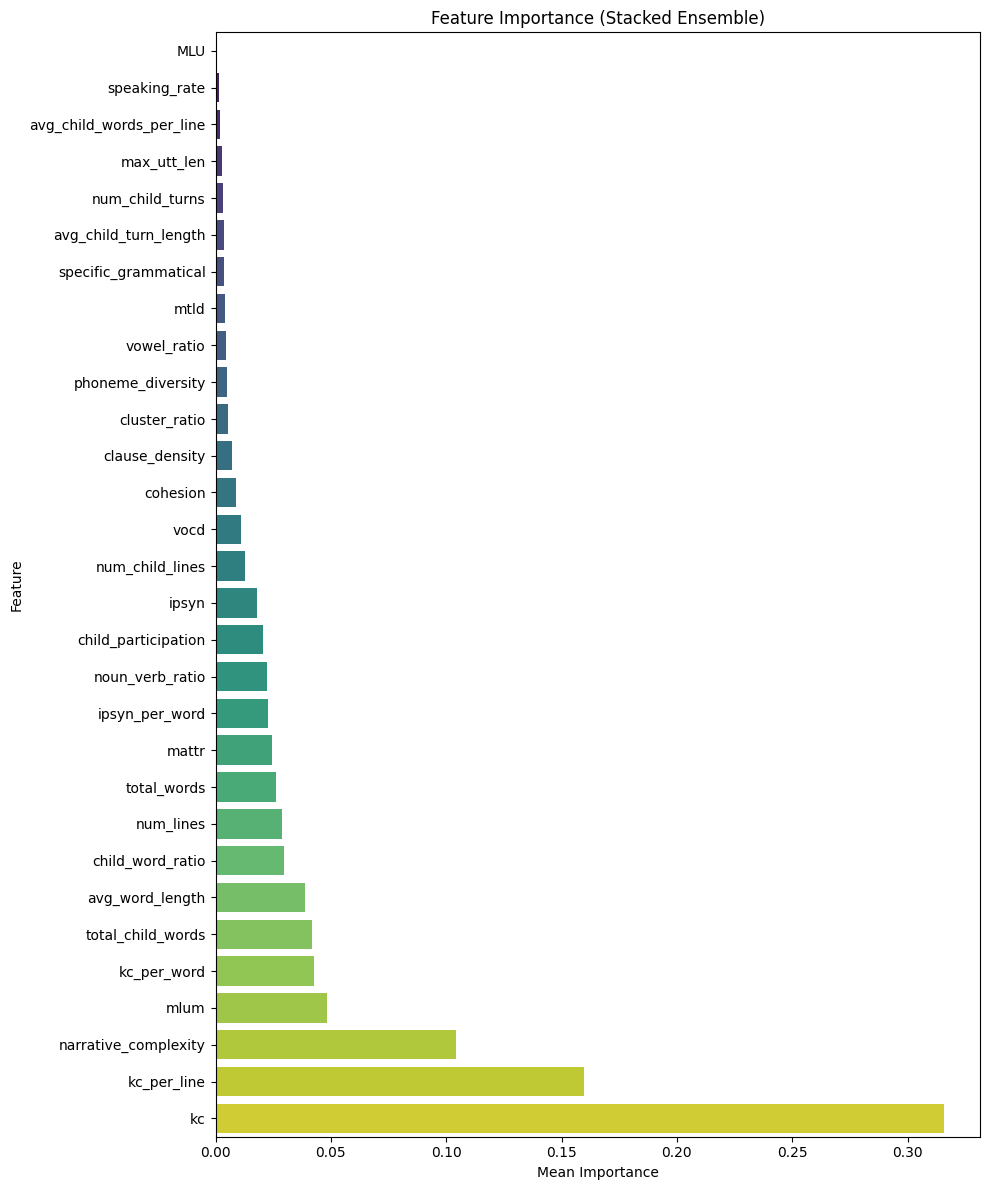

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the features by importance for plotting
importance_df_sorted = importance_df.sort_values("Mean Importance", ascending=True)

plt.figure(figsize=(10, 12))
sns.barplot(x="Mean Importance", y="Feature", data=importance_df_sorted, palette="viridis")
plt.title("Feature Importance (Stacked Ensemble)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Feature Engineering / Interaction Features

#### With validation

In [ ]:
# ------------------------------
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ------------------------------
# Helper: evaluate predictions
def evaluate(y_true, y_pred, name="Validation"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Results: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# ------------------------------
# Polynomial regression function
def run_polynomial_regression(train_df, val_df, test_df, feature_columns, degree=2, alpha=1.0):
    # -------------------------------
    # 1. Prepare features
    X_train = train_df[feature_columns].copy()
    X_val = val_df[feature_columns].copy()
    X_test = test_df[feature_columns].copy()

    # Replace inf and NaN
    for df_ in [X_train, X_val, X_test]:
        df_.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_.fillna(df_.median(), inplace=True)
        # Clip extreme values to avoid explosion
        df_ = df_.clip(-1e3, 1e3)

    y_train = train_df['child_age']
    y_val = val_df['child_age']
    y_test = test_df['child_age']

    # -------------------------------
    # 2. Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # 3. Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # -------------------------------
    # 4. Train Ridge regression
    reg_poly = Ridge(alpha=alpha)
    reg_poly.fit(X_train_poly, y_train)

    # -------------------------------
    # 5. Predict
    y_val_pred = reg_poly.predict(X_val_poly)
    y_test_pred = reg_poly.predict(X_test_poly)

    # -------------------------------
    # 6. Evaluate
    evaluate(y_val, y_val_pred, "Validation (Poly)")
    evaluate(y_test, y_test_pred, "Test (Poly)")

    return reg_poly, poly, scaler

# ------------------------------
# 7. Run for all 10 folds
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running Polynomial Regression for fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    # Split train into train/val (80/20)
    df_train_split, df_val_split = train_test_split(df_train, test_size=0.2, random_state=42)

    # Run polynomial regression (degree=2, Ridge alpha=1.0)
    run_polynomial_regression(df_train_split, df_val_split, df_test, feature_columns, degree=2, alpha=1.0)


--- Running Polynomial Regression for fold_1 ---
Validation (Poly) Results: R²=0.4532, MAE=8.1701, RMSE=10.4077
Test (Poly) Results: R²=0.4700, MAE=7.9108, RMSE=10.3086

--- Running Polynomial Regression for fold_2 ---
Validation (Poly) Results: R²=0.3783, MAE=8.1889, RMSE=10.7687
Test (Poly) Results: R²=0.3851, MAE=8.4189, RMSE=10.8745

--- Running Polynomial Regression for fold_3 ---
Validation (Poly) Results: R²=0.4470, MAE=8.1427, RMSE=10.4512
Test (Poly) Results: R²=0.3332, MAE=8.9207, RMSE=11.7192

--- Running Polynomial Regression for fold_4 ---
Validation (Poly) Results: R²=-0.1529, MAE=8.3844, RMSE=14.7497
Test (Poly) Results: R²=0.4664, MAE=8.2648, RMSE=10.4193

--- Running Polynomial Regression for fold_5 ---
Validation (Poly) Results: R²=0.4686, MAE=7.8617, RMSE=10.2513
Test (Poly) Results: R²=0.1334, MAE=9.7200, RMSE=13.5865

--- Running Polynomial Regression for fold_6 ---
Validation (Poly) Results: R²=0.4220, MAE=7.9030, RMSE=10.0664
Test (Poly) Results: R²=0.5488, MAE=

#### Without validation

In [ ]:
# ------------------------------
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# Helper: evaluate predictions
def evaluate(y_true, y_pred, name="Test"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Results: R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

# ------------------------------
# Polynomial regression function (robust)
def run_polynomial_regression_full(train_df, test_df, feature_columns, degree=2, alpha=5.0):
    # Prepare features
    X_train = train_df[feature_columns].copy()
    X_test = test_df[feature_columns].copy()

    # Replace inf, NaN
    for df_ in [X_train, X_test]:
        df_.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_.fillna(df_.median(), inplace=True)
        # Clip extreme values to prevent explosion
        df_.clip(lower=-1e2, upper=1e2, inplace=True)

    y_train = train_df['child_age']
    y_test = test_df['child_age']

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train Ridge regression
    reg_poly = Ridge(alpha=alpha)
    reg_poly.fit(X_train_poly, y_train)

    # Predict
    y_test_pred = reg_poly.predict(X_test_poly)

    # Evaluate
    evaluate(y_test, y_test_pred, "Test (Poly)")

    return reg_poly, poly, scaler

# ------------------------------
# Run on all 10 folds
base_dir = "/content/drive/MyDrive/Final_Project/splits"

for i in range(1, 11):
    print(f"\n--- Running Polynomial Regression for fold_{i} ---")
    fold_dir = f"{base_dir}/fold_{i}"

    df_train = pd.read_csv(f"{fold_dir}/train.csv")
    df_test = pd.read_csv(f"{fold_dir}/test.csv")

    run_polynomial_regression_full(df_train, df_test, feature_columns, degree=2, alpha=5.0)


--- Running Polynomial Regression for fold_1 ---
Test (Poly) Results: R²=0.5970, MAE=7.0721, RMSE=8.9895

--- Running Polynomial Regression for fold_2 ---
Test (Poly) Results: R²=0.4627, MAE=7.8639, RMSE=10.1651

--- Running Polynomial Regression for fold_3 ---
Test (Poly) Results: R²=0.1851, MAE=9.0970, RMSE=12.9550

--- Running Polynomial Regression for fold_4 ---
Test (Poly) Results: R²=0.4502, MAE=8.2433, RMSE=10.5762

--- Running Polynomial Regression for fold_5 ---
Test (Poly) Results: R²=0.3455, MAE=9.0890, RMSE=11.8068

--- Running Polynomial Regression for fold_6 ---
Test (Poly) Results: R²=0.4645, MAE=7.5092, RMSE=10.4458

--- Running Polynomial Regression for fold_7 ---
Test (Poly) Results: R²=0.4882, MAE=8.0658, RMSE=9.9703

--- Running Polynomial Regression for fold_8 ---
Test (Poly) Results: R²=-0.0057, MAE=8.0271, RMSE=13.7085

--- Running Polynomial Regression for fold_9 ---
Test (Poly) Results: R²=0.4201, MAE=7.8752, RMSE=10.0876

--- Running Polynomial Regression for

In [ ]:
import numpy as np
import pandas as pd

splits = [
    # fold 1
    {
        "RF": {"R2": 0.6097, "MAE": 7.1308, "RMSE": 8.8463},
        "HGB": {"R2": 0.6404, "MAE": 6.7470, "RMSE": 8.4914},
        "CatBoost": {"R2": 0.6563, "MAE": 6.4391, "RMSE": 8.3017},
        "Stack": {"R2": 0.6647, "MAE": 6.3865, "RMSE": 8.1994},
    },
    # fold 2
    {
        "RF": {"R2": 0.5549, "MAE": 7.5208, "RMSE": 9.2518},
        "HGB": {"R2": 0.5541, "MAE": 7.1886, "RMSE": 9.2598},
        "CatBoost": {"R2": 0.5641, "MAE": 7.2427, "RMSE": 9.1556},
        "Stack": {"R2": 0.5755, "MAE": 7.1613, "RMSE": 9.0358},
    },
    # fold 3
    {
        "RF": {"R2": 0.4590, "MAE": 8.5095, "RMSE": 10.5560},
        "HGB": {"R2": 0.4796, "MAE": 8.1964, "RMSE": 10.3530},
        "CatBoost": {"R2": 0.5107, "MAE": 7.9518, "RMSE": 10.0384},
        "Stack": {"R2": 0.5300, "MAE": 7.9596, "RMSE": 9.8387},
    },
    # fold 4
    {
        "RF": {"R2": 0.4753, "MAE": 8.1986, "RMSE": 10.3323},
        "HGB": {"R2": 0.5366, "MAE": 7.3110, "RMSE": 9.7099},
        "CatBoost": {"R2": 0.5382, "MAE": 7.3443, "RMSE": 9.6937},
        "Stack": {"R2": 0.5674, "MAE": 7.0741, "RMSE": 9.3818},
    },
    # fold 5
    {
        "RF": {"R2": 0.5363, "MAE": 8.1292, "RMSE": 9.9377},
        "HGB": {"R2": 0.5553, "MAE": 7.7536, "RMSE": 9.7319},
        "CatBoost": {"R2": 0.5818, "MAE": 7.6301, "RMSE": 9.4384},
        "Stack": {"R2": 0.5839, "MAE": 7.5798, "RMSE": 9.4141},
    },
    # fold 6
    {
        "RF": {"R2": 0.6249, "MAE": 7.0749, "RMSE": 8.7427},
        "HGB": {"R2": 0.6546, "MAE": 6.7457, "RMSE": 8.3893},
        "CatBoost": {"R2": 0.6522, "MAE": 6.7047, "RMSE": 8.4188},
        "Stack": {"R2": 0.6708, "MAE": 6.4447, "RMSE": 8.1898},
    },
    # fold 7
    {
        "RF": {"R2": 0.5423, "MAE": 7.7237, "RMSE": 9.4286},
        "HGB": {"R2": 0.5094, "MAE": 7.7936, "RMSE": 9.7616},
        "CatBoost": {"R2": 0.5568, "MAE": 7.4331, "RMSE": 9.2780},
        "Stack": {"R2": 0.5616, "MAE": 7.4310, "RMSE": 9.2282},
    },
    # fold 8
    {
        "RF": {"R2": 0.5779, "MAE": 7.0221, "RMSE": 8.8806},
        "HGB": {"R2": 0.5839, "MAE": 6.7777, "RMSE": 8.8177},
        "CatBoost": {"R2": 0.5837, "MAE": 6.8052, "RMSE": 8.8198},
        "Stack": {"R2": 0.5964, "MAE": 6.7376, "RMSE": 8.6839},
    },
    # fold 9
    {
        "RF": {"R2": 0.4835, "MAE": 7.2503, "RMSE": 9.5204},
        "HGB": {"R2": 0.4884, "MAE": 7.1466, "RMSE": 9.4749},
        "CatBoost": {"R2": 0.5153, "MAE": 7.0572, "RMSE": 9.2226},
        "Stack": {"R2": 0.5296, "MAE": 7.1059, "RMSE": 9.0862},
    },
    # fold 10
    {
        "RF": {"R2": 0.5617, "MAE": 7.3977, "RMSE": 9.2390},
        "HGB": {"R2": 0.5847, "MAE": 6.9861, "RMSE": 8.9933},
        "CatBoost": {"R2": 0.6007, "MAE": 6.8369, "RMSE": 8.8186},
        "Stack": {"R2": 0.6078, "MAE": 6.8518, "RMSE": 8.7400},
    },
]

In [ ]:
models = ["RF", "HGB", "CatBoost", "Stack"]
results = []

for model in models:
    mae_list = [split[model]["MAE"] for split in splits]
    rmse_list = [split[model]["RMSE"] for split in splits]
    r2_list = [split[model]["R2"] for split in splits]

    results.append({
        "Model": model,
        "MAE_mean": np.mean(mae_list),
        "RMSE_mean": np.mean(rmse_list),
        "R2_mean": np.mean(r2_list)
    })

df_results = pd.DataFrame(results)
print("===== Average Results over 10 Splits =====")
print(df_results)

===== Average Results over 10 Splits =====
      Model  MAE_mean  RMSE_mean  R2_mean
0        RF   7.59576    9.47354  0.54255
1       HGB   7.26463    9.29828  0.55870
2  CatBoost   7.14451    9.11856  0.57598
3     Stack   7.07323    8.97979  0.58877


## Diagnostic & Analysis script

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ========== CONFIGURATION ==========
base_dir = "/content/drive/MyDrive/Final_Project/splits"
target_column = 'child_age'

# Initialize summary storage
fold_results = []
feature_importance_summary = {}

# ========== FUNCTION ==========
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return {"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse, "Residuals": y_test - y_pred, "Predictions": y_pred}


# ========== MAIN LOOP ==========
for i in range(1, 11):
    print(f"\n--- Running fold_{i} ---")
    fold_path = os.path.join(base_dir, f"fold_{i}")

    # Load train/test data
    train_df = pd.read_csv(os.path.join(fold_path, "train.csv"))
    test_df = pd.read_csv(os.path.join(fold_path, "test.csv"))

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]
    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    # Replace inf/-inf with NaN
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN
    train_nan_before = X_train.isna().sum().sum()
    test_nan_before = X_test.isna().sum().sum()
    if train_nan_before or test_nan_before:
        print(f"Cleaning fold_{i}: dropped {train_nan_before} NaNs in train, {test_nan_before} NaNs in test")
        X_train = X_train.dropna()
        y_train = y_train.loc[X_train.index]
        X_test = X_test.dropna()
        y_test = y_test.loc[X_test.index]

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models
    models = {
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.01),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
    }

    fold_metrics = []

    for name, model in models.items():
        metrics = evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)
        fold_metrics.append(metrics)
        print(f"{name}: R²={metrics['R2']:.4f}, MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")

        # Track feature importances (tree models only)
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            for f, imp in zip(feature_columns, importances):
                feature_importance_summary.setdefault(f, []).append(imp)

    fold_results.extend([{**m, "Fold": i} for m in fold_metrics])


# ========== SUMMARY ==========
results_df = pd.DataFrame(fold_results)
print("\n===== CROSS-FOLD RESULTS =====")
print(results_df.groupby("Model")[["R2", "MAE", "RMSE"]].mean().sort_values("R2", ascending=False))

# Feature importance summary
if feature_importance_summary:
    feature_importance_df = pd.DataFrame({
        "Feature": list(feature_importance_summary.keys()),
        "Mean Importance": [np.mean(v) for v in feature_importance_summary.values()]
    }).sort_values("Mean Importance", ascending=False)
    print("\n===== FEATURE IMPORTANCE (AVG OVER FOLDS) =====")
    print(feature_importance_df)

# Save results
results_df.to_csv("/content/drive/MyDrive/Final_Project/diagnostic_results.csv", index=False)
if feature_importance_summary:
    feature_importance_df.to_csv("/content/drive/MyDrive/Final_Project/feature_importance_summary.csv", index=False)

print("\nDiagnostics complete ✅")


--- Running fold_1 ---
Cleaning fold_1: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.5304, MAE=7.86, RMSE=9.70
Lasso: R²=0.5297, MAE=7.86, RMSE=9.71
RandomForest: R²=0.6118, MAE=6.98, RMSE=8.82
GradientBoosting: R²=0.6341, MAE=6.74, RMSE=8.57

--- Running fold_2 ---
Cleaning fold_2: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.4466, MAE=8.40, RMSE=10.32
Lasso: R²=0.4460, MAE=8.40, RMSE=10.32
RandomForest: R²=0.5689, MAE=7.25, RMSE=9.11
GradientBoosting: R²=0.5292, MAE=7.48, RMSE=9.52

--- Running fold_3 ---
Cleaning fold_3: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.4238, MAE=8.85, RMSE=10.89
Lasso: R²=0.4211, MAE=8.88, RMSE=10.92
RandomForest: R²=0.4906, MAE=8.18, RMSE=10.24
GradientBoosting: R²=0.5016, MAE=8.07, RMSE=10.13

--- Running fold_4 ---
Cleaning fold_4: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.4172, MAE=8.66, RMSE=10.89
Lasso: R²=0.4198, MAE=8.66, RMSE=10.86


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.855e+01, tolerance: 3.262e+01
  model = cd_fast.enet_coordinate_descent(


RandomForest: R²=0.4912, MAE=7.88, RMSE=10.17
GradientBoosting: R²=0.5117, MAE=7.74, RMSE=9.97

--- Running fold_5 ---
Cleaning fold_5: dropped 0 NaNs in train, 1 NaNs in test
Ridge: R²=0.4459, MAE=9.03, RMSE=10.88
Lasso: R²=0.4430, MAE=9.06, RMSE=10.91
RandomForest: R²=0.5452, MAE=8.00, RMSE=9.86
GradientBoosting: R²=0.5518, MAE=7.95, RMSE=9.78

--- Running fold_6 ---
Cleaning fold_6: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.5575, MAE=7.62, RMSE=9.49
Lasso: R²=0.5571, MAE=7.64, RMSE=9.50
RandomForest: R²=0.6336, MAE=6.99, RMSE=8.64
GradientBoosting: R²=0.6160, MAE=7.11, RMSE=8.85

--- Running fold_7 ---
Cleaning fold_7: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.4651, MAE=8.46, RMSE=10.19
Lasso: R²=0.4647, MAE=8.46, RMSE=10.20
RandomForest: R²=0.5599, MAE=7.51, RMSE=9.25
GradientBoosting: R²=0.5317, MAE=7.70, RMSE=9.54

--- Running fold_8 ---
Cleaning fold_8: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.5185, MAE=7.59, RMSE=9.49
Lasso: R²=0.5213, MAE=7.54, R

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.291e+01, tolerance: 3.287e+01
  model = cd_fast.enet_coordinate_descent(


RandomForest: R²=0.5788, MAE=7.01, RMSE=8.87
GradientBoosting: R²=0.5753, MAE=6.80, RMSE=8.91

--- Running fold_9 ---
Cleaning fold_9: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.3908, MAE=8.24, RMSE=10.34
Lasso: R²=0.3944, MAE=8.21, RMSE=10.31


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+01, tolerance: 3.313e+01
  model = cd_fast.enet_coordinate_descent(


RandomForest: R²=0.4987, MAE=7.12, RMSE=9.38
GradientBoosting: R²=0.4867, MAE=7.23, RMSE=9.49

--- Running fold_10 ---
Cleaning fold_10: dropped 1 NaNs in train, 0 NaNs in test
Ridge: R²=0.4731, MAE=8.10, RMSE=10.13
Lasso: R²=0.4657, MAE=8.14, RMSE=10.20
RandomForest: R²=0.5648, MAE=7.30, RMSE=9.21
GradientBoosting: R²=0.5821, MAE=7.08, RMSE=9.02

===== CROSS-FOLD RESULTS =====
                        R2       MAE       RMSE
Model                                          
RandomForest      0.554340  7.420756   9.354528
GradientBoosting  0.552014  7.390500   9.376795
Ridge             0.466896  8.280241  10.232408
Lasso             0.466288  8.285820  10.238722

===== FEATURE IMPORTANCE (AVG OVER FOLDS) =====
                     Feature  Mean Importance
13               kc_per_line         0.439622
17      narrative_complexity         0.061492
9                      mattr         0.043403
12               kc_per_word         0.042042
7                       mtld         0.035469
6     

## New features that capture subtle age differences

we already have most of the standard lexical, syntactic, and MLU-related features, we can add new features that capture subtle age differences in ways your current features don’t

### Interaction / ratio features

Highlight relative differences rather than absolute values

In [ ]:
df['kc_per_turn'] = df['kc'] / df['num_child_turns']           # complexity per child turn
df['clause_per_word'] = df['clause_density'] / df['total_child_words']  # clauses relative to words
df['word_participation_ratio'] = df['total_child_words'] / df['total_words']  # how much the child speaks compared to adult
df['ipsyn_per_turn'] = df['ipsyn'] / df['num_child_turns']    # syntactic diversity per turn

In [ ]:
new_features = ['kc_per_turn', 'clause_per_word', 'word_participation_ratio', 'ipsyn_per_turn']
df[new_features + ['child_age']].corr()['child_age']

,child_age
kc_per_turn,0.528233
clause_per_word,0.015463
word_participation_ratio,0.235468
ipsyn_per_turn,0.461695
child_age,1.000000


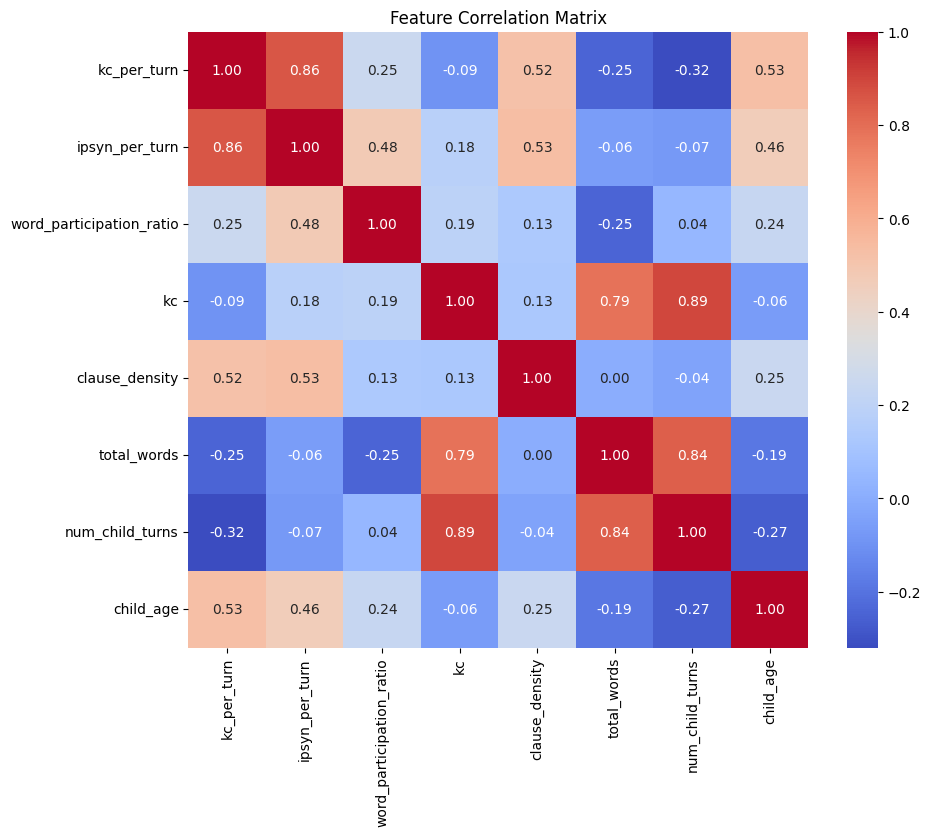

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns including new features
features_to_check = [
    'kc_per_turn', 'ipsyn_per_turn', 'word_participation_ratio',
    'kc', 'clause_density', 'total_words', 'num_child_turns', 'child_age'
]

# Compute correlation matrix
corr_matrix = df[features_to_check].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

kc_per_turn (0.53) – Moderate positive correlation with age. Older children tend to produce more complex utterances per turn. Useful

ipsyn_per_turn (0.46) – Moderate correlation. Older children show higher syntactic diversity per turn. Useful

word_participation_ratio (0.24) – Low correlation. The proportion of child speech compared to adults does not strongly indicate age. Less informative

clause_per_word (0.015) – Almost no correlation. Clauses per word are not predictive of age in this dataset. Not useful

Summary: Only kc_per_turn and ipsyn_per_turn are moderately helpful for predicting age. The other two features provide little predictive value.

### Conversational dynamics
Features that compare child vs adult contributions

In [ ]:
df['child_turn_ratio'] = df['num_child_turns'] / df['num_lines']
df['child_vs_adult_words'] = df['total_child_words'] / (df['total_words'] - df['total_child_words'])

In [ ]:
features = ['child_turn_ratio', 'child_vs_adult_words', 'child_age']

# Compute correlation
corr_matrix = df[features].corr()
print(corr_matrix['child_age'].sort_values(ascending=False))

child_age               1.000000
child_turn_ratio        0.126105
child_vs_adult_words    0.013215
Name: child_age, dtype: float64


These features likely won’t improve model accuracy much. You should focus on features with higher correlations (like kc_per_turn or ipsyn_per_turn) or try engineering more nuanced ones that capture linguistic complexity.

### Complexity normalized by activity
Helps compare children who talk more vs less:

In [ ]:
df['kc_per_word_per_turn'] = df['kc'] / (df['total_child_words'] * df['num_child_turns'])
df['narrative_per_turn'] = df['narrative_complexity'] / df['num_child_turns']

In [ ]:
new_features = ['kc_per_word_per_turn', 'narrative_per_turn']
print(df[new_features + ['child_age']].corr()['child_age'])

kc_per_word_per_turn    0.206190
narrative_per_turn      0.307029
child_age               1.000000
Name: child_age, dtype: float64


For now, the most promising features for predicting child age are kc_per_turn, ipsyn_per_turn, and narrative_per_turn. Other features either show very low correlation or need better engineering to become informative.

### Sequential features

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

def compute_avg_word_length(conversation):
    """
    Computes average word length per child utterance.
    Returns the mean across all child utterances.
    """
    child_utterances = [line for speaker, line in conversation if speaker == 'CHI']

    if not child_utterances:
        return 0

    avg_word_lengths = []

    for utterance in child_utterances:
        words = word_tokenize(utterance)
        if words:
            avg_len = sum(len(word) for word in words) / len(words)
        else:
            avg_len = 0
        avg_word_lengths.append(avg_len)

    return sum(avg_word_lengths) / len(avg_word_lengths)

df['avg_word_len'] = df['conversation_json'].apply(compute_avg_word_length)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

def utterance_complexity(utterance):
    words = word_tokenize(utterance)
    if not words:
        return 0
    return sum(len(w) for w in words) / len(words)

In [ ]:
def child_turns(conversation):
    """
    Returns list of child utterances.
    Supports both list of tuples (speaker, line)
    or list of dicts {"speaker": ..., "line": ...}
    """
    child_utterances = []
    for item in conversation:
        if isinstance(item, tuple) and len(item) == 2:
            speaker, line = item
        elif isinstance(item, dict):
            speaker, line = item.get('speaker'), item.get('line')
        else:
            continue
        if speaker == 'CHI' and line:
            child_utterances.append(line)
    return child_utterances

In [ ]:
def compute_turn_complexity_features(conversation):
    child_utterances = child_turns(conversation)

    if not child_utterances:
        return 0, 0, 0  # or np.nan if you prefer

    first_complexity = utterance_complexity(child_utterances[0])
    last_complexity = utterance_complexity(child_utterances[-1])
    complexity_change = last_complexity - first_complexity

    return first_complexity, last_complexity, complexity_change

In [ ]:
df[['first_turn_complexity', 'last_turn_complexity', 'complexity_change']] = \
    df['conversation_json'].apply(lambda conv: pd.Series(compute_turn_complexity_features(conv)))

In [ ]:
df[['first_turn_complexity', 'last_turn_complexity', 'complexity_change']].head()

,first_turn_complexity,last_turn_complexity,complexity_change
0,4.000000,6.000000,2.000000
1,3.333333,3.000000,-0.333333
2,3.500000,2.333333,-1.166667
3,3.000000,4.000000,1.000000
4,4.000000,2.750000,-1.250000


In [ ]:
import pandas as pd

# Assuming your features are already computed and added to df:
# 'first_turn_complexity', 'last_turn_complexity', 'complexity_change'

# 1. Correlation with numeric age
numeric_cols = ['first_turn_complexity', 'last_turn_complexity', 'complexity_change', 'child_age']
print("Correlation with child_age:")
print(df[numeric_cols].corr()['child_age'])

# 2. Correlation with categorical age_bin_readable
# Convert categorical to numeric codes first
df['age_bin_code'] = df['age_bin_readable'].astype('category').cat.codes
categorical_cols = ['first_turn_complexity', 'last_turn_complexity', 'complexity_change', 'age_bin_code']
print("\nCorrelation with age_bin_readable:")
print(df[categorical_cols].corr()['age_bin_code'])

Correlation with child_age:
first_turn_complexity   -0.052756
last_turn_complexity    -0.102917
complexity_change       -0.040453
child_age                1.000000
Name: child_age, dtype: float64

Correlation with age_bin_readable:
first_turn_complexity   -0.044754
last_turn_complexity    -0.084904
complexity_change       -0.032493
age_bin_code             1.000000
Name: age_bin_code, dtype: float64


### Entropy

In [ ]:
from collections import Counter
from scipy.stats import entropy
import numpy as np
from nltk.tokenize import word_tokenize

def compute_word_entropy(conversation):
    """
    Compute word entropy for all child utterances in a conversation.
    conversation: list of (speaker, utterance)
    """
    # get child utterances
    child_utterances = [line for speaker, line in conversation if speaker == 'CHI']

    # combine all words
    words = []
    for utt in child_utterances:
        words.extend(word_tokenize(utt))

    if not words:
        return 0

    counts = np.array(list(Counter(words).values()))
    return entropy(counts, base=2)  # base 2 gives entropy in bits

# apply to dataframe
df['word_entropy'] = df['conversation_json'].apply(compute_word_entropy)

In [ ]:
df.groupby('age_bin_readable')['vocd'].describe()

,count,mean,std,min,25%,50%,75%,max
age_bin_readable,,,,,,,,
2-3,524.0,37.005211,18.784991,1.277081,21.197485,35.924126,50.153226,91.451401
3-5,847.0,48.642633,20.292291,1.498619,32.769296,49.405461,62.580027,108.993292
5-6,460.0,49.409179,20.634853,5.704418,32.405914,48.422494,65.157617,102.334844


In [ ]:
age_mapping = {bin_label: i for i, bin_label in enumerate(sorted(df['age_bin_readable'].unique()))}
df['age_bin_code'] = df['age_bin_readable'].map(age_mapping)

features = ['first_turn_complexity', 'last_turn_complexity', 'complexity_change', 'vocd', 'mtld', 'mattr', 'mlum']

print("Correlation with child_age:")
print(df[features + ['child_age']].corr()['child_age'])

print("\nCorrelation with age_bin_code:")
print(df[features + ['age_bin_code']].corr()['age_bin_code'])

Correlation with child_age:
first_turn_complexity   -0.052756
last_turn_complexity    -0.102917
complexity_change       -0.040453
vocd                     0.280053
mtld                     0.470586
mattr                    0.478493
mlum                     0.464458
child_age                1.000000
Name: child_age, dtype: float64

Correlation with age_bin_code:
first_turn_complexity   -0.044754
last_turn_complexity    -0.084904
complexity_change       -0.032493
vocd                     0.225621
mtld                     0.430054
mattr                    0.440785
mlum                     0.436170
age_bin_code             1.000000
Name: age_bin_code, dtype: float64


### Repetition

In [ ]:
df['word_repetition_rate'] = df['total_child_words'] / df['unique_words']

## Evaluate Model Using Prompts

In this section, we evaluate the child age prediction model by providing GPT with prompts containing few-shot examples and conversation context. We compare the model’s predicted age groups with the true age_bin_readable values, compute accuracy, and analyze mispredictions to understand the impact of prompt design on performance.

### Predict Child Age Groups Using GPT-3.5

This section improves the previous approach by including 1–2 adult lines before each child utterance as context. This gives GPT more information about what the child is responding to, improving prediction accuracy. The pipeline handles token limits, cleans special tokens, truncates long conversations, and computes accuracy.

In [ ]:
# ------------------ HEADER ------------------

import pandas as pd
import random
import ast
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key="---")

# ------------------ DATA PREPARATION ------------------

# Ensure 'conversation' column is proper Python list
df['conversation'] = df['conversation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Clean special tokens
def clean_text(text):
    return text.replace("UNRECOGNIZED_WORD", "[unintelligible]").replace("UNK", "[unknown]")

# ------------------ FUNCTION: CHILD LINES + CONTEXT ------------------

def conv_to_text_with_context(conv_list, context_window=1):
    """
    Extract child lines with a few lines of adult context.
    context_window: number of previous lines to include before CHI line.
    """
    lines = []
    for i, item in enumerate(conv_list):
        if isinstance(item, (tuple, list)) and len(item) == 2:
            speaker, text = item
            if speaker == 'CHI':
                # Include previous 'context_window' adult lines
                start_idx = max(0, i - context_window)
                context_lines = []
                for j in range(start_idx, i):
                    prev_speaker, prev_text = conv_list[j]
                    if prev_speaker != 'CHI':
                        context_lines.append(f"{prev_speaker}: {clean_text(prev_text)}")
                # Add current CHI line
                context_lines.append(f"{speaker}: {clean_text(text)}")
                lines.append(" ".join(context_lines))
    return " ".join(lines)

# ------------------ STEP 1: Build few-shot examples ------------------

age_bins = df['age_bin_readable'].unique()
n_examples_per_bin = 2  # examples per age bin
few_shot_examples = ""

for bin_val in age_bins:
    few_rows = df[df['age_bin_readable'] == bin_val].sample(
        n=min(n_examples_per_bin, len(df[df['age_bin_readable'] == bin_val])), random_state=42
    )
    for _, row in few_rows.iterrows():
        conv_text = conv_to_text_with_context(row['conversation'], context_window=1)
        # Truncate to 200 words to avoid token overflow
        conv_words = conv_text.split()
        if len(conv_words) > 200:
            conv_text = " ".join(conv_words[:200])
        few_shot_examples += f"""
Conversation: {conv_text}
Age group: {row['age_bin_readable']}
"""

# ------------------ STEP 2: Sample test rows ------------------

n_samples = min(20, len(df))
sample_df = df.sample(n=n_samples, random_state=24).copy()

# ------------------ STEP 3: Build prompt template ------------------

prompt_template = f"""
You are a child development expert.

Below are examples of conversations with their correct age groups:
{few_shot_examples}

Now, given the following conversation between a mother (MOT) and her child (CHI), estimate the child's age and assign it to an age group.

Important:
- "CHI" means child
- "MOT" means mother
- "INV" means interviewer
- "ADU", "GMA", "UNK" are other adults
- Focus on the child's words (vocabulary, sentence length, complexity) to decide the age group

Conversation: {{conversation_text}}

Answer format: Age group: <{', '.join(age_bins)}>
"""

# ------------------ STEP 4: Generate predictions ------------------

predicted_age_bins = []

for conv in sample_df['conversation']:
    conv_text = conv_to_text_with_context(conv, context_window=1)
    # Truncate long text to 300 words
    conv_words = conv_text.split()
    if len(conv_words) > 300:
        conv_text = " ".join(conv_words[:300])

    prompt = prompt_template.format(conversation_text=conv_text)

    # Call GPT
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    pred = response.choices[0].message.content.strip()
    pred_clean = pred.split(":")[-1].strip()
    predicted_age_bins.append(pred_clean)

# ------------------ STEP 5: Store predictions and evaluate ------------------

sample_df['predicted_age_bin_clean'] = predicted_age_bins
sample_df['age_bin_clean'] = sample_df['age_bin_readable'].str.extract(r'(\d-\d)')[0]
sample_df['correct'] = sample_df['predicted_age_bin_clean'] == sample_df['age_bin_clean']

# Accuracy
accuracy = sample_df['correct'].mean()
print(f"Accuracy on random sample: {accuracy:.2%}")

# Show mispredictions
misclassified = sample_df[sample_df['correct'] == False][['conversation','age_bin_clean','predicted_age_bin_clean']]
print(misclassified)

Accuracy on random sample: 65.00%
                                           conversation age_bin_clean  \
1416  [(CHI, this is for you Mama), (CHI, this is fo...           3-5   
1680  [(ADU, what do you wanna play with?), (CHI, we...           3-5   
810   [(MOT, come here Chi come over here), (CHI, yo...           5-6   
476   [(MOT, let me try it on), (MOT, I might like i...           3-5   
1829  [(UNK, what that lady's name?), (UNK, Steve do...           3-5   
623   [(INV, I want you to give us a look at this wi...           3-5   
462   [(GMA, UNRECOGNIZED_WORD turn the table over a...           3-5   

     predicted_age_bin_clean  
1416                     2-3  
1680                     2-3  
810                      2-3  
476                      2-3  
1829                     2-3  
623                      2-3  
462                      5-6  


### Improve predict Child Age Groups Using GPT-3.5

In [ ]:
# ------------------ HEADER ------------------

import pandas as pd
import random
import ast
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key="---")

# ------------------ DATA PREPARATION ------------------

# Ensure 'conversation' column is a proper Python list
df['conversation'] = df['conversation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Function to convert conversation tuples to text
def conv_to_text(conv_list, keep_speaker=None):
    """
    Convert conversation tuples to text.
    keep_speaker: 'CHI' to keep only child lines, None to keep all speakers.
    """
    lines = []
    for item in conv_list:
        if isinstance(item, (tuple, list)) and len(item) == 2:
            speaker, text = item
            if keep_speaker is None or speaker == keep_speaker:
                lines.append(f"{speaker}: {text}")
    return " ".join(lines)

# Clean special tokens
def clean_text(text):
    return text.replace("UNRECOGNIZED_WORD", "[unintelligible]").replace("UNK", "[unknown]")

# ------------------ STEP 1: Prepare few-shot examples ------------------

age_bins = df['age_bin_readable'].unique()
few_shot_examples = ""

for bin_val in age_bins:
    # Take the first example of this age bin
    row = df[df['age_bin_readable'] == bin_val].iloc[0]

    # Use only CHI lines
    conv_text = conv_to_text([(s, clean_text(t)) for s, t in row['conversation']], keep_speaker='CHI')

    # Truncate to 200 words max
    conv_words = conv_text.split()
    if len(conv_words) > 200:
        conv_text = " ".join(conv_words[:200])

    few_shot_examples += f"""
Conversation: {conv_text}
Age group: {row['age_bin_readable']}
"""

print("Few-shot examples prepared for all age bins.")

# ------------------ STEP 2: Sample test rows ------------------

n_samples = min(20, len(df))
sample_df = df.sample(n=n_samples, random_state=24).copy()

# ------------------ STEP 3: Build prompt template ------------------

prompt_template = f"""
You are a child development expert.

Below are examples of conversations with their correct age groups:
{few_shot_examples}

Now, given the following conversation between a mother (MOT) and her child (CHI), estimate the child's age and assign it to an age group.

Important:
- "CHI" means child
- "MOT" means mother
- "INV" means interviewer
- "ADU", "GMA", "UNK" are other adults
- Focus on the child's words (vocabulary, sentence length, complexity) to decide the age group

Conversation: {{conversation_text}}

Answer format: Age group: <{', '.join(age_bins)}>
"""

# ------------------ STEP 4: Generate predictions ------------------

predicted_age_bins = []

for conv in sample_df['conversation']:
    # Use only CHI lines for prediction
    conv_text = conv_to_text([(s, clean_text(t)) for s, t in conv], keep_speaker='CHI')
    # Truncate if too long
    conv_words = conv_text.split()
    if len(conv_words) > 300:
        conv_text = " ".join(conv_words[:300])

    prompt = prompt_template.format(conversation_text=conv_text)

    # Call GPT
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    # Extract predicted age bin
    pred = response.choices[0].message.content.strip()
    pred_clean = pred.split(":")[-1].strip()
    predicted_age_bins.append(pred_clean)

# ------------------ STEP 5: Store predictions and evaluate ------------------

sample_df['predicted_age_bin_clean'] = predicted_age_bins
sample_df['age_bin_clean'] = sample_df['age_bin_readable'].str.extract(r'(\d-\d)')[0]
sample_df['correct'] = sample_df['predicted_age_bin_clean'] == sample_df['age_bin_clean']

# Accuracy
accuracy = sample_df['correct'].mean()
print(f"Accuracy on random sample: {accuracy:.2%}")

# Show mispredictions
misclassified = sample_df[sample_df['correct'] == False][['conversation','age_bin_clean','predicted_age_bin_clean']]
print(misclassified)

Few-shot examples prepared for all age bins.
Accuracy on random sample: 70.00%
                                           conversation age_bin_clean  \
1416  [(CHI, this is for you Mama), (CHI, this is fo...           3-5   
810   [(MOT, come here Chi come over here), (CHI, yo...           5-6   
623   [(INV, I want you to give us a look at this wi...           3-5   
462   [(GMA, UNRECOGNIZED_WORD turn the table over a...           3-5   
267   [(INV, will you help me make a nice picture?),...           2-3   
1590  [(MOT, what do you think?), (CHI, there's two ...           2-3   

     predicted_age_bin_clean  
1416                     2-3  
810                      3-5  
623                      2-3  
462                      5-6  
267                      3-5  
1590                     3-5  


In [ ]:
# ------------------ HEADER ------------------
import pandas as pd
import ast
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI(api_key="---")

# ------------------ DATA PREPARATION ------------------
# Ensure 'conversation' column is proper Python list
df['conversation'] = df['conversation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Clean special tokens
def clean_text(text):
    return text.replace("UNRECOGNIZED_WORD", "[unintelligible]").replace("UNK", "[unknown]").replace("ADU", "[adult]")

# Normalize child text
def normalize_child_text(text):
    return clean_text(text).lower()

# ------------------ FUNCTION: CHILD LINES + CONTEXT ------------------
def conv_to_text_with_context(conv_list, context_window=1):
    """
    Extract child lines with a few lines of adult context.
    context_window: number of previous lines to include before CHI line.
    """
    lines = []
    for i, item in enumerate(conv_list):
        if isinstance(item, (tuple, list)) and len(item) == 2:
            speaker, text = item
            if speaker == 'CHI':
                # Include previous 'context_window' adult lines
                start_idx = max(0, i - context_window)
                context_lines = []
                for j in range(start_idx, i):
                    prev_speaker, prev_text = conv_list[j]
                    if prev_speaker != 'CHI':
                        context_lines.append(f"{prev_speaker}: {normalize_child_text(prev_text)}")
                # Add current CHI line
                context_lines.append(f"{speaker}: {normalize_child_text(text)}")
                lines.append(" ".join(context_lines))
    return " ".join(lines)

# ------------------ STEP 1: Build few-shot examples (1 per age bin) ------------------
age_bins = df['age_bin_readable'].unique()
few_shot_examples = ""

for bin_val in age_bins:
    # Pick 1 representative row per age bin
    row = df[df['age_bin_readable'] == bin_val].sample(n=1, random_state=42).iloc[0]
    conv_text = conv_to_text_with_context(row['conversation'], context_window=1)
    conv_words = conv_text.split()
    if len(conv_words) > 200:
        conv_text = " ".join(conv_words[:200])
    few_shot_examples += f"""
Conversation: {conv_text}
Age group: {row['age_bin_readable']}
"""

print("Few-shot examples prepared for all age bins.")

# ------------------ STEP 2: Sample test rows ------------------
n_samples = min(20, len(df))
sample_df = df.sample(n=n_samples, random_state=24).copy()

# ------------------ STEP 3: Build prompt template ------------------
prompt_template = f"""
You are a child development expert.

Below are examples of conversations with their correct age groups:
{few_shot_examples}

Now, given the following conversation between a mother (MOT) and her child (CHI), estimate the child's age and assign it to an age group.

Important:
- "CHI" means child
- "MOT" means mother
- "INV" means interviewer
- "ADU", "GMA", "UNK" are other adults
- Focus on the child's words, vocabulary, sentence length, and complexity to decide the age group

Conversation: {{conversation_text}}

Answer format: Age group: <{', '.join(age_bins)}>
"""

# ------------------ STEP 4: Generate predictions ------------------
predicted_age_bins = []

for conv in sample_df['conversation']:
    conv_text = conv_to_text_with_context(conv, context_window=1)
    conv_words = conv_text.split()
    if len(conv_words) > 300:
        conv_text = " ".join(conv_words[:300])  # take first 300 words

    prompt = prompt_template.format(conversation_text=conv_text)

    # Call GPT
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )

    pred = response.choices[0].message.content.strip()
    pred_clean = pred.split(":")[-1].strip()
    predicted_age_bins.append(pred_clean)

# ------------------ STEP 5: Store predictions and evaluate ------------------
sample_df['predicted_age_bin_clean'] = predicted_age_bins
sample_df['age_bin_clean'] = sample_df['age_bin_readable'].str.extract(r'(\d-\d)')[0]
sample_df['correct'] = sample_df['predicted_age_bin_clean'] == sample_df['age_bin_clean']

# Accuracy
accuracy = sample_df['correct'].mean()
print(f"Accuracy on random sample: {accuracy:.2%}")

# Show mispredictions
misclassified = sample_df[sample_df['correct'] == False][['conversation','age_bin_clean','predicted_age_bin_clean']]
print(misclassified)

Few-shot examples prepared for all age bins.
Accuracy on random sample: 70.00%
                                           conversation age_bin_clean  \
810   [(MOT, come here Chi come over here), (CHI, yo...           5-6   
1613  [(MOT, I came home late), (CHI, what's in here...           2-3   
623   [(INV, I want you to give us a look at this wi...           3-5   
970   [(MOT, Chi would you mind just telling the lad...           3-5   
462   [(GMA, UNRECOGNIZED_WORD turn the table over a...           3-5   
1590  [(MOT, what do you think?), (CHI, there's two ...           2-3   

     predicted_age_bin_clean  
810                      3-5  
1613                     3-5  
623                      2-3  
970                      5-6  
462                      5-6  
1590                     3-5  


## Enhanced Prediction Using Numeric Features Combined with GEMINI Embeddings

In [ ]:
import pandas as pd
import numpy as np

# Load GEMINI embeddings dataset
df = pd.read_pickle("/content/drive/MyDrive/Final_Project/splits_with_embeddings/test_df_split10_with_embeddings.pkl")

# Numeric features (the same as before)
feature_columns = [
    'num_lines', 'num_child_lines', 'total_words', 'total_child_words',
    'avg_child_words_per_line', 'child_participation', 'child_word_ratio',
    'mtld', 'vocd', 'mattr', 'mlum', 'kc', 'kc_per_word', 'kc_per_line',
    'clause_density', 'ipsyn', 'ipsyn_per_word', 'narrative_complexity',
    'num_child_turns', 'avg_child_turn_length', 'cohesion', 'MLU',
    'max_utt_len', 'speaking_rate', 'avg_word_length', 'vowel_ratio',
    'cluster_ratio', 'phoneme_diversity', 'noun_verb_ratio', 'specific_grammatical'
]

# Extract numeric features
X_numeric = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Convert GEMINI embeddings from list to numpy array
X_embeddings = np.vstack(df['embedding'].values)

# Combine numeric features + embeddings
X_combined = np.hstack([X_numeric.values, X_embeddings])

# Target
y = df['child_age'].values

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_combined = imputer.fit_transform(X_combined)

# Scale features
scaler = RobustScaler()
X_combined = scaler.fit_transform(X_combined)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

R²=0.5625, MAE=7.9171, RMSE=9.3895


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

base_models = {
    "rf": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "gbr": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "hgb": HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42),
    "cat": CatBoostRegressor(iterations=400, learning_rate=0.05, depth=6, verbose=0, random_seed=42),
    "ridge": Ridge(alpha=1.0),
    "mlp": MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam', max_iter=500, random_state=42)
}

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X_combined.shape[0], len(base_models)))
test_preds = np.zeros((X_test.shape[0], len(base_models)))  # keep test for averaging

for fold, (train_idx, val_idx) in enumerate(kf.split(X_combined)):
    print(f"Fold {fold+1}/5")
    X_tr, X_val = X_combined[train_idx], X_combined[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    for i, (name, model) in enumerate(base_models.items()):
        model.fit(X_tr, y_tr)
        oof_preds[val_idx, i] = model.predict(X_val)
        test_preds[:, i] += model.predict(X_test) / kf.n_splits

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
